In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pickle

from tool_functions.feature_fuser import *

feature_path = []
rgb_path = []
true_label_path = []
size = 0

folder_path = '/home/xi/centauro_img/'
feature_file_list = os.listdir(folder_path)
for file_name in feature_file_list:
    if file_name.find('.npy') != -1:
        # print(file_name[:-13])
        rgb_p = folder_path + file_name[:-13] + '.jpg'
        label_p = folder_path + file_name[:-13] + '_label.png'
        path = file_name

        feature_path.append(folder_path + path)
        rgb_path.append(rgb_p)
        true_label_path.append(label_p)

print('feature loaded:', len(feature_path))

def process_feature(f_img):
    result_img = np.full(f_img.shape, 0, dtype=np.uint8)
    for row in range(f_img.shape[0]):
        for col in range(f_img.shape[1]):
            f_v = f_img[row, col]
            if f_v > 0.2:
                result_img[row, col] = 255

    return result_img


image loaded: 81
feature loaded: 35


In [4]:
def load_feature_file():
    count = 0
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []
    
    test_index = np.random.choice(20, 15, replace=False)
    
    for (feature_file, rgb_file, l_file) in zip(feature_path, rgb_path, true_label_path):
        features_map = np.load(feature_file)
        rgb_img = cv2.imread(rgb_file, 1)
        true_label_img = cv2.imread(l_file, 0)
        
        is_train = True
        for t_i in test_index:
            if count == t_i:
                is_train = False
                break
        print(is_train, feature_file, count)
        count += 1

        # features = features_map[:,:,:-1]
        # labels =   features_map[:,:,-1]
    
        # shape = features.shape
        # features_reshaped = features.reshape(shape[0]*shape[1], shape[2])

        for row in range(size, features_map.shape[0]-size, 1+size):
            for col in range(size, features_map.shape[1]-size, 1+size):
                feature = features_map[row-size:row+size+1, col-size:col+size+1, :-1].flatten()
                label = features_map[row, col, -1]
                if label != -1 and label != 0:
                    if is_train:
                        train_features.append(feature)
                        train_labels.append(label)
                    else:
                        test_features.append(feature)
                        test_labels.append(label)
                        
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)
    
    print(train_features.shape, test_features.shape)

    return train_features, train_labels, test_features, test_labels, test_index

In [5]:
train_features, train_labels, test_features, test_labels, test_index = load_feature_file()

False /home/xi/centauro_img/stairs_lappis_4_0000_features.npy 0
False /home/xi/centauro_img/stairs_universitetet_2_0000_features.npy 1
False /home/xi/centauro_img/stairs_tek31_2_0000_features.npy 2
True /home/xi/centauro_img/stairs_universitetet_3_0000_features.npy 3
True /home/xi/centauro_img/stairs_lappis_6_0000_features.npy 4
False /home/xi/centauro_img/stairs_museum_behind_1_0000_features.npy 5
False /home/xi/centauro_img/terrain_tek30_2_0000_features.npy 6
False /home/xi/centauro_img/stairs_lappis_1_0000_features.npy 7
True /home/xi/centauro_img/stairs_museum_side_2_0000_features.npy 8
True /home/xi/centauro_img/stairs_lappis_7_0000_features.npy 9
False /home/xi/centauro_img/stairs_museum_side_3_0000_features.npy 10
False /home/xi/centauro_img/stairs_universitetet_5_0000_features.npy 11
False /home/xi/centauro_img/stairs_opposite_tek14_3_0000_features.npy 12
False /home/xi/centauro_img/stairs_museum_down_2_0000_features.npy 13
False /home/xi/centauro_img/stairs_lappis_5_0000_featu

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_features)

X_train = scaler.transform(train_features)
X_test = scaler.transform(test_features)

y_train = train_labels
y_test = test_labels

# X = StandardScaler().fit_transform(all_features)
# X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=.4, random_state=42)


In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=30, n_estimators=10, max_features=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
import pickle

pickle.dump(clf, open("/home/xi/workspace/terrain_classifier/tc_model.pickle","wb"), protocol=2)
pickle.dump(scaler, open("/home/xi/workspace/terrain_classifier/tc_model_scaler.pickle","wb"), protocol=2)

# joblib.dump(clf, '/home/xi/workspace/terrain_classifier/tc_model.pickle', protocol=2)
# joblib.dump(scaler, '/home/xi/workspace/terrain_classifier/tc_model_scaler.pickle', protocol=2)

score = clf.score(X_test, y_test)
print (score)

0.890024263688


In [16]:
import pickle
clf = pickle.load(open('/home/xi/workspace/terrain_classifier/tc_model.pickle', 'rb'))
scaler = pickle.load(open('/home/xi/workspace/terrain_classifier/tc_model_scaler.pickle', 'rb'))
score = clf.score(X_test, y_test)
print (score)

[  1.33538637e-01   8.00351069e-02   7.02482984e-02   4.30042929e+00
   1.85382129e-01   3.35937104e-06   1.08117430e-05   6.59159520e-06
   2.79749549e-05   3.72067017e-05   2.18815003e-05   5.58348322e-01
   6.19138898e-02   1.77248754e-02   7.16630208e-05   1.04157012e-04
   4.36392438e-02   1.50487695e-02   4.62772376e-02   1.82094718e-04
   1.34852122e-04   3.62896087e-05   4.16471109e-03   3.49799276e-06
   2.76912605e-05   2.35181616e-03   1.73173064e-02   1.67768283e-01
   2.16368495e-04   5.22105506e-03   2.22189571e-04   3.52986388e-03
   3.98932234e-03   1.45042102e-03   3.74745657e-02   6.06842868e-03
   5.69634959e-04   4.36863369e-05   5.99194740e-03]
0.890024263688


In [17]:
def normalize_img(img, max_value):
    
    img_clip = np.clip(img, 0, max_value)
    
    img_norm = img_clip/max_value *255
    
    return img_norm

(540, 960, 39)
predicting.....
predected! (518400,)


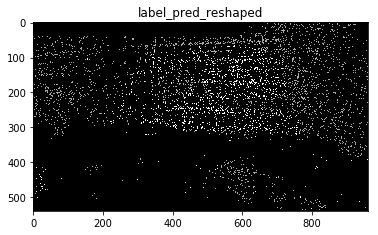

In [38]:
for i in range(1, 2, 1):

    index = test_index[i]
    feature_file = feature_path[index]
    rgb_file = rgb_path[index]
    l_file = true_label_path[index]
    
    features = np.load(feature_file)
    features_map = features[:,:,:-1]
    print(features_map.shape)
    
    stair_img = features_map[:,:,4]
    rgb_img = cv2.imread(rgb_file, 1)
    true_label_img = cv2.imread(l_file, 0)
    
    
    features_map_reshape = features_map.reshape((features_map.shape[0]*features_map.shape[1], features_map.shape[2]))
    feature_nromalized = scaler.transform(features_map_reshape)
    print('predicting.....')
    label_pred = clf.predict(feature_nromalized)
    print('predected!', label_pred.shape)
    label_pred_reshaped = label_pred.reshape((features_map.shape[0], features_map.shape[1]))

    plt.imshow(label_pred_reshaped, cmap='gray')
    plt.title('label_pred_reshaped')
    plt.show()

    for row in range(features_map.shape[0]):
        for col in range(features_map.shape[1]):
            label_pred = label_pred_reshaped[rol, col]
            
            if label_pred == 4: #stair
                cv2.circle(rgb_img, (col, row), 3, (255, 255, 0), -1)
            if label_pred == 3: #obs
                cv2.circle(rgb_img, (col, row), 3, (0, 255, 0), -1)     
            if label_pred == 2: #rough
                cv2.circle(rgb_img, (col, row), 3, (0, 255, 255), -1)  
            if label_pred == 1: #safe
                cv2.circle(rgb_img, (col, row), 3, (0, 0, 255), -1) 
    

/home/xi/centauro_img/stairs_tek31_2_0000_features.npy
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.756464421749
0.924655258656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.756464421749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.525050282478
0.136567592621
0.156781971455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.487560510635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.833432972431
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.316897690296
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.645456254482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.56383138895
-1.0
-1.0
-1.0
0.703611969948
0.384227454662
-1.0
-1.0
-1.0
0.415532827377
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168138384819
0.524373412132
-1.0
-1.0
0.391522526741
-1.0
-1.0
0.595701336861
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
0.452283978462
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
0.12452930212
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.672692894936
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.954648315907
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.756464421749
-1.0
-1.0
-1.0
-1.0
-1.0
0.113222718239
-1.0
0.919739067554
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.954648315907
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.825237214565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.525050282478
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.975315272808
0.0739107131958
-1.0
-1.0
0.378050863743
0.947465002537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.44967353344
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.67493724823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.54936504364
0.294789731503
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.63935226202
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.41613805294
-1.0
-1.0
-1.0
-1.0
0.469245493412
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165463209152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.232194125652
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.657910108566
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.300826370716
-1.0
-1.0
0.700011610985
-1.0
-1.0
-1.0
-1.0
-1.0
0.130994975567
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0116901397705
-1.0
0.0119205713272
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0926489830017
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.139383614063
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.674575805664
-1.0
-1.0
-1.0
-1.0
0.725178897381
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.334374666214
-1.0
-1.0
-1.0
-1.0
0.0129620432854
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.538732349873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.243013933301
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.57855463028
-1.0
-1.0
-1.0
0.208028674126
-1.0
0.55943185091
-1.0
-1.0
-1.0
0.285576701164
-1.0
-1.0
-1.0
-1.0
0.376867055893
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.342425316572
-1.0
-1.0
-1.0
0.56383138895
-1.0
0.570595741272
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.645456254482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


0.349365532398
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.222284793854
-1.0
-1.0
-1.0
-1.0
0.99026954174
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.469245493412
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.364164948463
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0684229135513
-1.0
-1.0
0.0908864438534
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.806133627892
-1.0
-1.0
-1.0
-1.0
0.713133692741
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.656111240387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974076986313
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.18959055841
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.119557678699
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.110758721828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.328934967518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.428978443146
-1.0
-1.0
0.655162930489
-1.0
-1.0
-1.0
-1.0
-1.0
0.687056362629
-1.0
0.660619497299
-1.0
0.0058119893074
-1.0
-1.0
0.379902243614
-1.0
0.725178897381
-1.0
-1.0
0.263594567776
-1.0
-1.0
0.300826370716
-1.0
0.700011610985
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0129525661469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
0.623826503754
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.316897690296
0.506508946419
-1.0
-1.0
-1.0
0.552888154984
-1.0
-1.0
-1.0
-1.0
0.459429681301
-1.0
-1.0
-1.0
-1.0
-1.0
0.607596874237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978643476963
-1.0
-1.0
-1.0
-1.0
-1.0
0.98522901535
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.204727113247
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.237985193729
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.273605942726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165178835392
0.125673592091
-1.0
-1.0
0.165178835392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0105699896812
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158704817295
-1.0
-1.0
0.00220143795013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.136478602886
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00276851654053
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.289455890656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165841162205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.148445487022
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167753100395
-1.0
-1.0
-1.0
-1.0
-1.0
0.174346089363
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16928589344
-1.0
0.985438883305
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171264886856
-1.0
0.0993911623955
-1.0
-1.0
-1.0
-1.0
0.169816553593
0.899132609367
-1.0
-1.0
0.899132609367
-1.0
0.174318909645
-1.0
-1.0
0.015641450882
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00866335630417
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.933547854424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.423539578915
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
0.0675949156284
-1.0
-1.0
0.161281049252
-1.0
-1.0
0.164128899574
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173255324364
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.654330134392
-1.0
0.161510229111
0.0114544630051
-1.0
-1.0
-1.0
-1.0
-1.0
0.160860478878
-1.0
-1.0
-1.0
-1.0
-1.0
0.780348598957
-1.0
-1.0
-1.0
-1.0
0.209754288197
-1.0
-1.0
0.209754288197
0.979462146759
-1.0
-1.0
-1.0
0.189007401466
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.251277208328
-1.0
0.431532263756
-1.0
-1.0
0.822367012501
-1.0
-1.0
-1.0
0.0154534578323
0.567135810852
-1.0
-1.0
-1.0
-1.0
0.83568239212
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.757087945938
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.45374506712
-1.0
-1.0
-1.0
-1.0
0.0498027205467
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00606769323349
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987297832966
-1.0
-1.0
-1.0
-1.0
-1.0
0.98641294241
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157437562943
-1.0
-1.0
-1.0
0.0408663749695
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00968033075333
0.921106636524
0.250315964222
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157118827105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.461812853813
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.150824964046
-1.0
0.208058774471
-1.0
0.208058774471
-1.0
-1.0
0.150824964046
-1.0
-1.0
-1.0
0.135273635387
-1.0
-1.0
-1.0
-1.0
-1.0
0.157147288322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.335398107767
-1.0
-1.0
-1.0
-1.0
0.0444867610931
0.168291389942
0.0181024074554
-1.0
0.143230438232
-1.0
-1.0
-1.0
-1.0
-1.0
0.0182873010635
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.571911096573
-1.0
0.010993540287
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.909243702888
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.31947311759
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.755330622196
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.59179931879
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.662850141525
-1.0
0.413811951876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.648898839951
-1.0
0.601929485798
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
0.130334466696
-1.0
-1.0
-1.0
0.237985193729
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00669658184052
-1.0
-1.0
-1.0
-1.0
0.130334466696
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00734692811966
-1.0
-1.0
-1.0
-1.0
0.986478686333
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.208058774471
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.520151376724
-1.0
-1.0
0.018038213253
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.155253648758
-1.0
-1.0
0.169894576073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987653195858
-1.0
0.168221652508
-1.0
0.167753100395
-1.0
-1.0
-1.0
-1.0
0.153154551983
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.103039085865
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0124378204346
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0645327270031
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00605738162994
-1.0
0.1656580567

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.107998669147
-1.0
0.728782474995
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0151568055153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.937030315399
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.659012615681
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.524373412132
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.524373412132
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.208028674126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
0.0107478499413
-1.0
-1.0
0.975932717323
0.00434726476669
0.120616257191
0.0137971043587
0.0106666684151
0.0193320512772
-1.0
-1.0
-1.0
-1.0
-1.0
0.12898850441
0.00735819339752
-1.0
0.0147836208344
-1.0
0.138677656651
-1.0
0.148201167583
-1.0
-1.0
-1.0
-1.0
-1.0
0.107759356499
-1.0
-1.0
-1.0
0.00974529981613
-1.0
-1.0
-1.0
0.192271888256
0.328934967518
0.216411590576
0.205007016659
-1.0
-1.0
0.0212151408195
-1.0
-1.0
-1.0
-1.0
-1.0
0.0387508273125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0674996376038
-1.0
-1.0
0.487560510635
-1.0
0.205215990543
-1.0
-1.0
-1.0
0.248660266399
0.469245493412
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.226989626884
0.205215990543
-1.0
0.0572411417961
-1.0
0.0374784469604
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.34444129467
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.63490319252
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.756464421749
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.977234244347
0.239534437656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00962030887604
-1.0
-1.0
-1.0
-1.0
0.712642550468
-1.0
0.204838097095
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0160908102989
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00402319431305
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157933652401
-1.0
-1.0
0.157466232777
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.147465765476
0.289455890656
-1.0
-1.0
-1.0
0.155202627182
-1.0
-1.0
-1.0
0.0117408037186
-1.0
0.155253648758
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00810438394547
0.18725168705
0.00633656978607
-1.0
-1.0
0.37814360857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00943845510483
0.520151376724
-1.0
-1.0
-1.0
-1.0
0.181673794985
-1.0
-1.0
-1.0
-1.0
-1.0
0.00789040327072
0.674089729786
-1.

-1.0
-1.0
-1.0
0.101950407028
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.469245493412
-1.0
-1.0
-1.0
-1.0
-1.0
0.661068379879
-1.0
-1.0
0.0771061778069
-1.0
-1.0
0.205215990543
-1.0
-1.0
-1.0
-1.0
0.421022236347
0.898068189621
-1.0
-1.0
-1.0
-1.0
-1.0
0.185321211815
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.110621511936
0.146097302437
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161832988262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.127075910568
-1.0
0.677736997604
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.677736997604
-1.0
-1.0
-1.0
0.983460962772
-1.0
-1.0
-1.0
-1.0
0.00933492183685
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.101432621479
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.694988369942
-1.0
-1.0
-1.0
-1.0
0.977979123592
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.290212482214
-1.0
0.919739067554
-1.0
-1.0
-1.0
-1.0
0.176528602839
-1.0
-1.0
-1.0
-1.0
-1.

0.116159915924
0.00333607196808
0.237985193729
-1.0
-1.0
0.441921681166
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.192271888256
-1.0
-1.0
0.259021699429
-1.0
-1.0
-1.0
0.013353407383
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0148631334305
-1.0
-1.0
0.813531756401
0.130334466696
-1.0
-1.0
0.79760235548
0.135273635387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00801032781601
-1.0
-1.0
-1.0
0.00732094049454
-1.0
-1.0
0.0444867610931
-1.0
-1.0
-1.0
0.0
0.127281725407
-1.0
-1.0
-1.0
0.557067275047
0.0059220790863
-1.0
0.00901192426682
-1.0
-1.0
-1.0
0.608824491501
-1.0
0.00901192426682
-1.0
-1.0
0.205007016659
-1.0
-1.0
0.1602216959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169462949038
0.172977030277
-1.0
-1.0
0.160647690296
-1.0
-1.0
-1.0
0.00480782985687
-1.0
-1.0
-1.0
-1.0
0.131075739861
-1.0
-1.0
0.144964039326
0.0056529045105
0.00775396823883
-1.0
-1.0
0.00556409358978
0.520151376724
-1.0
-1.0
0.148742139339
-1.0
0.00633656978607
-1.0
0.0109329223633
0.1767753064

0.00819742679596
-1.0
-1.0
-1.0
0.153202950954
0.110612928867
-1.0
-1.0
-1.0
-1.0
0.00659036636353
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.869701206684
-1.0
0.869701206684
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.341738760471
-1.0
-1.0
-1.0
-1.0
0.00787925720215
-1.0
0.357057660818
-1.0
-1.0
-1.0
0.00813102722168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.356271982193
-1.0
-1.0
-1.0
-1.0
-1.0
0.525050282478
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.363413751125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.392347276211
-1.0
0.63935226202
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
0.0111495256424
-1.0
0.14500528574
0.0124851465225
0.15839523077
0.00263726711273
0.189591705799
-1.0
-1.0
-1.0
-1.0
0.200557887554
-1.0
-1.0
-1.0
0.00800043344498
0.11812543869
-1.0
-1.0
0.0094518661499
0.0143120288849
-1.0
0.0202627778053
-1.0
-1.0
-1.0
-1.0
0.00885009765625
-1.0
0.0
-1.0
-1.0
-1.0
0.00740838050842
-1.0
-1.0
-1.0
-1.0
-1.0
0.00611048936844
-1.0
-1.0
-1.0
0.00744271278381
-1.0
-1.0
-1.0
-1.0
0.189591705799
-1.0
-1.0
0.211858093739
-1.0
-1.0
-1.0
0.214354157448
0.211858093739
-1.0
0.00986272096634
-1.0
-1.0
-1.0
-1.0
0.010692179203
0.141088068485
0.00697094202042
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0118789672852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0127428770065
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00973570346832
-1.0
-1.0
-1.0
0.00522208213806
-1.0
-1.0
0.153154551983
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
0.00843286514282
0.0060967206955
0.154325962067
0.0079020857811
0.0096418261528
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00577646493912
0.00430601835251
-1.0
-1.0
-1.0
0.00274062156677
-1.0
0.0
0.00533151626587
0.157333254814
-1.0
-1.0
-1.0
-1.0
0.135273635387
0.157933652401
-1.0
-1.0
0.158704817295
-1.0
-1.0
-1.0
-1.0
0.170625507832
-1.0
0.131863892078
0.160596728325
0.00255960226059
0.122697949409
-1.0
0.0055359005928
-1.0
-1.0
0.158704817295
-1.0
-1.0
-1.0
0.0182873010635
-1.0
-1.0
-1.0
0.00220417976379
-1.0
-1.0
-1.0
0.284285098314
-1.0
-1.0
-1.0
-1.0
-1.0
0.00182247161865
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161316156387
-1.0
0.00710558891296
-1.0
-1.0
-1.0
0.168103933334
-1.0
0.157966852188
-1.0
-1.0
0.00839298963547
-1.0
-1.0
-1.0
0.0118408799171
0.00551557540894
-1.0
-1.0
-1.0
0.161316156387
-1.0
0.211858093739
-1.0
0.18725168705
-1.0
-1.0
0.15724915266
-1.0
-1.0
-1.0
-1.0
-1.0
0.193276524544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.295364439487
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267610549927
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989927411079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
0.977234244347
-1.0
-1.0
-1.0
0.982687115669
-1.0
-1.0
0.0138774514198
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987297832966
-1.0
-1.0
-1.0
-1.0
-1.0
0.862812817097
-1.0
0.951267540455
-1.0
-1.0
-1.0
0.687163949013
-1.0
-1.0
-1.0
-1.0
0.67025244236
0.580878138542
0.976145207882
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987297832966
-1.0
-1.0
0.530699014664
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.163612902164
-

-1.0
0.014931499958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.35843527317
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.645456254482
0.659012615681
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.500506043434
-1.0
-1.0
-1.0
-1.0
-1.0
0.35843527317
-1.0
-1.0
-1.0
-1.0
-1.0
0.0476624369621
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.506508946419
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.259021699429
0.0447260737419


-1.0
-1.0
0.0739107131958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.427719831467
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
0.57255011797
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.607596874237
0.129470542073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.458236932755
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.652669250965
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.959

-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.13963919878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.933924674988
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.35843527317
-1.0
-1.0
0.972754836082
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.623067259789
-1.0
0.607596874237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0201502740383
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.662850141525
-1.0
-1.0
-

0.302376031876
0.972754836082
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.866549372673
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.623067259789
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0038857460022
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.877393126488
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.61251115799
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.477057695389
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987580358982
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.880226194859
-1.0
-1.0
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989927411079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.951267540455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.991935074329
-1.0
0.991935074

-1.0
-1.0
-1.0
-1.0
-1.0
0.910603523254
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.524373412132
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.857560992241
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.502702653408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
-1.0
-1.0
0.30531257391
-1.0
-1.0
-1.0
0.0149621367455
-1.0
0.0322572886944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.159522712231
-1.0
0.989927411079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989927411079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
0.55943185091
0.85396617651
-1.0
-1.0
-1.0
0.524373412132
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.278424918652
-1.0
-1.0
-1.0
-1.0
0.239058375359
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0106914043427
-1.0
-1.0
0.221965491772
0.0120773911476
0.00943356752396
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.983454227448
0.987297832966
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
0.623067259789
-1.0
-1.0
-1.0
0.456957101822
-1.0
-1.0
-1.0
-1.0
-1.0
0.35843527317
-1.0
-1.0
-1.0
-1.0
-1.0
0.0669130682945
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.98126655817
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.96128064394
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.63935226202
0.998179554939
-1.0
-1.0
0.662850141525
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.595701336861
0.45201343298
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998767018318
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.1624066

-1.0
-1.0
-1.0
-1.0
-1.0
0.654330134392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177774846554
-1.0
-1.0
-1.0
-1.0
-1.0
0.788903713226
-1.0
-1.0
0.657855451107
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0101472139359
-1.0
0.0939847826958
-1.0
-1.0
-1.0
0.654330134392
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.789871513844
-1.0
-1.0
-1.0
0.726840496063
-1.0
-1.0
-1.0
-1.0
-1.0
0.387235403061
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.57255011797
-1.0
-1.0
0.623826503754
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0148034095764
-1.0
-1.0
-1.0
-1.0
-1.0
0.165287554264
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.138191223145
-1.0
0.162636220455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.536567926407
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.496482223272
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.963553369045
-1.0
-1.0
0.0151973366737
0.00189793109894
-1.0
-1.0
-1.0
-1.0
0.177774846554
0.00704735517502
0.0061782002449
0.657855451107
-1.0
-1.0
-1.0
0.718137204647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.470200538635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0892388224602
0.158876419067
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.657855451107
-1.0
-1.0
-1.0
-1.0
-1.0
-1

0.0109329223633
0.214354157448
-1.0
-1.0
-1.0
0.214354157448
0.0102822184563
0.13763576746
-1.0
0.254973232746
-1.0
-1.0
-1.0
0.14500528574
-1.0
0.0103202462196
-1.0
-1.0
0.211858093739
-1.0
0.00664222240448
-1.0
-1.0
-1.0
0.167753100395
0.16404312849
0.168221652508
0.14500528574
0.00480782985687
0.0131347775459
-1.0
-1.0
0.00884735584259
-1.0
0.0
0.144964039326
-1.0
0.0132830739021
-1.0
0.16928589344
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00771218538284
0.00782251358032
-1.0
0.00721400976181
-1.0
-1.0
0.109966576099
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.10066485405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17261248827
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
0.00594383478165
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.150824964046
-1.0
-1.0
0.00249618291855
-1.0
-1.0
0.00943356752396
-1.0
-1.0
0.00736653804779
0.165178835392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00152492523193
0.00495195388794
-1.0
-1.0
-1.0
0.00910973548889
-1.0
-1.0
-1.0
0.00237864255905
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.192864894867
-1.0
-1.0
-1.0
-1.0
0.00446629524231
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17837458849
-1.0
-1.0
-1.0
-1.0
-1.0
0.155202627182
-1.0
-1.0
-1.0
-1.0
-1.0
0.00789040327072
-1.0
-1.0
-1.0
-1.0
-1.0
0.847819983959
-1.0
0.0184068083763
0.143230438232
0.00475174188614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00964605808258
-1.0
-1.0
-1.0
0.478856027126
-1.0
-1.0
0.131863892078
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.189591705799
-1.0
0.00256222486496
-1.0
-1.0
0.169420957565
-1.0
0.081297814846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0074427

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162406623363
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157147288322
-1.0
-1.0
0.138413369656
-1.0
0.00307500362396
-1.0
0.00339132547379
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.129877209663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.192271888256
-1.0
-1.0
-1.0
-1.0
0.157933652401
-1.0
-1.0
0.00267738103867
-1.0
0.00611990690231
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.520151376724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00766277313232
0.0100337862968
0.00954484939575
-1.0
-1.0
-1.0
0.00572550296783
-1.0
-1.0
-1.0
0.382446467876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157966852188
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161489844322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165178835392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00815397500992
-1.0
-1.0
-1.0
0.00631308555603
-1.0
0.144574403763
-1.0
-1.0
-1.0
0.135273635387
0.00801032781601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00734782218933
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.206592261791
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157966852188
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0131516456604
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00505000352859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.147788226604
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.130608022213
-1.0
-1.0
0.00801032781601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.163620769978
-1.0
-1.0
-1.0
0.283773124218
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.405635595322
-1.0
-1.0
0.0104624629021
-1.0
-1.0
0.157933652401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00798833370209
-1.0
-1.0
-1.0
-1.0
-1.0
0.14269220829
-1.0
-1.0
-1.0
-1.0
0.133879721165
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.133879721165
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.122697949409
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0124378204346
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00763636827469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00936484336853
-1.0
-1.0
-1.0
-1.0
0.0168543457985
-1.0
-1.0
-1.0
-1.0
-1.0
0.00794035196304
-1.

-1.0
0.202056527138
0.844042181969
-1.0
-1.0
0.0123845934868
-1.0
-1.0
-1.0
0.170625507832
0.847819983959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161489844322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00428879261017
0.00601071119308
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00583678483963
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.14269220829
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170259773731
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.211136043072
-1.0
-1.0
0.142875909805
-1.0
-1.0
0.189591705799
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.115351319313
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.176421940327
-1.0
-1.0
-1.0
-1.0
-1.0
0.0101704597473
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.145720601082
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00424307584763
-1.0
-1.0
-1.0
-1.0
-1.0
0.0080286860466
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.131863892078
-1.0
-1.0
-1.0
-1.0
0.00974524021149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.201822578907
-1.0
-1.0
-1.0
-1.0
-1.0
0.37814360857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.15839523077
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16404312849
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0113735198975
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17466917634
-1.0
-1.0
-1.0
0.169797062874
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0087930560112
-1.0
-1.0
-1.0
0.426557302475
-1.0
-1.0
-1.0
-1.0
0.174318909645
-1.0
-1.0
-1.0
0.0117715597153
-1.0
-1.0
-1.0
-1.0
0.395142793655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.654330134392
-1.0
-1.0
-1.0
0.0101472139359
0.138677656651
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.701864957809
-1.0
-1.0
-1.0
-1.0
0.70186495780

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.896898925304
-1.0
-1.0
-1.0
-1.0
-1.0
0.12709403038
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.997585833073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.595701336861
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.962148964405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.626804947853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.601929485798
0.595701336861
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.54936504364
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.861843526363
-1.0
0.35843527317
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.822880625725
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.726842463017
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.98793399334
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.116907060146
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.843368470669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.656111240387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.656111240387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.421964466572
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.691397666931
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.849375009537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0410648584366
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.54936504364
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.35843527317
-1.0
0.57855463028
0.506508946419
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.524373412132
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.506508946419
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.506508946419
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0309127569199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.982687115669
-1.0
-1.0
-1.0
-1.0
-1.0
0.98268

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
0.897536039352
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.163754463196
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.865678429604
-1.0
-1.0
0.861843526363
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.871934235096
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.62864947319
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
0.136562943459
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0151060819626
-1.0
-1.0
0.00581938028336
-1.0
-1.0
-1.0
-1.0
-1.0
0.426557302475
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.721922278404
-1.0
0.0952377915382
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.163586318493
-1.0
-1.0
0.229960471392
-1.0
-1.0
0.76792883873
-1.0
0.799150884151
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.724762678146
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.812188386917
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.798636078835
-1.0
-1.0
-1.0
-1.0
0.387235403061
-1.0
-1.0
-1.0
-1

-1.0
-1.0
0.295364439487
-1.0
0.163586318493
-1.0
-1.0
-1.0
0.161941796541
-1.0
-1.0
-1.0
0.17206799984
-1.0
0.151311933994
-1.0
-1.0
-1.0
0.174318909645
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.106381833553
-1.0
-1.0
-1.0
0.172377794981
-1.0
0.151311933994
-1.0
-1.0
0.165658056736
-1.0
-1.0
-1.0
-1.0
0.0114544630051
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00953316688538
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.142465114594
-1.0
0.103039085865
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.134154558182
-1.0
0.0139704942703
-1.0
-1.0
-1.0
-1.0
0.0141088366508
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162636220455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.275625705719
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.199481546879
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168745994568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.138821005821
-1.0
-1.0
-1.0
0.165287554264
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170097649097
-1.0
0.170097649

-1.0
0.00777906179428
-1.0
0.160454928875
-1.0
-1.0
-1.0
-1.0
0.00892817974091
0.18725168705
-1.0
-1.0
0.0149427056313
-1.0
-1.0
0.214354157448
-1.0
0.15724915266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0645327270031
-1.0
-1.0
-1.0
-1.0
0.0150117874146
-1.0
-1.0
0.177016615868
0.15724915266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.160454928875
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0171877741814
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170456111431
-1.0
-1.0
0.0155140161514
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.140670895576
-1.0
-1.0
0.978076040745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00823760032654
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174346089363
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.211136043072
-1.0
-1.0
0.18725168705
-1.0
0.164772093296
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0114544630051
-1.0
-1.0
-1.0
-1.0
0.165270090103
-1.0
-1.0
-1.0
0.170456111431
-1.0
0.118668019772
-1.0
-1.0
-1.0
0.160275578499
-1.0
-1.0
-1.0
0.139729142189
-1.0
-1.0
-1.0
-1.0
0.165658056736
-1.0
-1.0
-1.0
-1.0
0.16404312849
-1.0
0.161572515965
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.142465114594
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.015764772892
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.138191223145
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174318909645
-1.0
-1.0

-1.0
0.160454928875
0.165841162205
-1.0
0.0120304226875
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161572515965
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170533120632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0168582201004
-1.0
-1.0
-1.0
0.160275578499
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140618085861
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16404312849
-1.0
-1.0
-1.0
-1.0
-1.0
0.169325232506
-1.0
-1.0
-1.0
0.0770456194878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170097649097
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16300791502
0.170097649097
-1.0
-1.0
0.00953316688538
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.535064339638
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171264886856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0770456194878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165287554264
-1.0
-1.0
0.160860478878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158876419067
0.0106083750725
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162636220455
-1.0
-1.0
0.137849867344
-1.0
-1.0
-1.0
-1.0
-1.0
0.00903856754303
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0110999941826
-1.0
-1.0
0.00825953483582
-1.0
-1.0
-1.0
0.164668798447
-1.0
-1.0
-1.0
-1.0
-1.0
0.00829142332077
0.165808856487
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170452594757
-1.0
-1.0
-1.0
-1.0
0.395142793655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173014879227
0.128634750843
-1.0
-1.0
-1.0
-1.0
0.721922278404
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
0.00944572687149
-1.0
-1.0
-1.0
0.138821005821
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0141651034355
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170097649097
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.171770632267
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.126212537289
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.137433111668
0.0758066773415
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.877393126488
0.779029726982
-1.0
-1.0
-1.0
-1.0
-1.0
0.680605769157
-1.0
-1.0
-1.0
-1.0
-1.0
0.759604215622
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.388164162636
-1.0
-1.0
0.780348598957
0.53728979826
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.657855451107
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.718757688999
-1.0
-1.0
-1.0
0.975932717323
-1.0
-1.0
0.759604215622
-1.0
0.759604215622
0.747295796871
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0939847826958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.426557302475
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00635004043579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.76792883873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.654330134392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.701864957809
0.718757688999
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.127282619476
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.788903713226
-1.0
-1.0
-1.0
0.997585833073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.718757688999
0.837158501148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.654330134392
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.718757688999
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.401669323444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.889223754406
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.84968906641
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.821748614311
-1.0
0.821748614311
-1.0
-1.0
-1.0
-1.0
0.8251

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.812188386917
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
0.726840496063
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.895096361637
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.84968906641
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.845081925392
-1.0
-

-1.0
-1.0
-1.0
-1.0
0.825177371502
-1.0
-1.0
-1.0
-1.0
0.80439722538
-1.0
0.80439722538
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.839133620262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.835947453976
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.870701789856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.891445815563
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.908726632595
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929498851299
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.250315964222
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.972231805325
-1.0
-1.0
0.972231805325
0.972231805325
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.242931306362
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.14327788353
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.683239400387
0.683239400387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165585160255
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.844042181969
-1.0
-1.0
0.130334466696
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157118827105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.683239400387
-1.0
-1.0
-1.0
-1.0
0.57003057003
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158214986324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.153613895178
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.152435302734
-1.0
0.152435302734
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157118827105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157933652401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.405635595322
-1.0
-1.0
-

-1.0
0.896898925304
-1.0
0.16300791502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178877413273
-1.0
-1.0
-1.0
0.701864957809
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
0.015764772892
-1.0
-1.0
-1.0
0.76792883873
-1.0
0.127282619476
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.127282619476
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00843036174774
0.515422105789
-1.0
-1.0
-1.0
-1.0
0.666097402573
-1.0
-1.0
-1.0
-1.0
-1.0
0.759604215622
0.667519748211
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.779029726982
-1.0
-1.0
-1.0
-1.0
0.657855451107
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.76792883873
0.994959294796
0.958043396473
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
0.8892

-1.0
0.0645327270031
-1.0
0.214354157448
-1.0
-1.0
0.0150117874146
-1.0
0.0144467949867
-1.0
0.176775306463
0.0109329223633
-1.0
-1.0
-1.0
-1.0
0.168221652508
-1.0
0.211136043072
-1.0
-1.0
-1.0
-1.0
0.177016615868
-1.0
-1.0
0.295364439487
-1.0
0.142875909805
-1.0
-1.0
-1.0
0.145720601082
0.15724915266
-1.0
0.160489559174
-1.0
-1.0
-1.0
0.177708506584
-1.0
-1.0
-1.0
-1.0
0.16627189517
0.0159227848053
-1.0
-1.0
0.167753100395
0.214354157448
-1.0
-1.0
0.160454928875
-1.0
-1.0
0.174318909645
-1.0
-1.0
0.170456111431
-1.0
0.16156411171
0.0213325619698
-1.0
-1.0
-1.0
0.0107163786888
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.156719565392
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0132177472115
-1.0
0.163823008537
-1.0
-1.0
-1.0
0.140983939171
-1.0
-1.0
0.16404312849
-1.0
-1.0
-1.0
0.165658056736
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170456111431
-1.0
0.16156411171
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174216061831
-1.0
-1.0
-1.0
-1

-1.0
0.134033024311
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0053209066391
0.00910729169846
-1.0
-1.0
-1.0
-1.0
0.00470879673958
-1.0
-1.0
-1.0
0.00470879673958
-1.0
-1.0
-1.0
-1.0
0.00470879673958
-1.0
-1.0
-1.0
-1.0
0.0133294165134
-1.0
-1.0
-1.0
0.0133294165134
0.0133294165134
-1.0
-1.0
-1.0
-1.0
0.00403586030006
-1.0
-1.0
-1.0
-1.0
0.00403586030006
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00684076547623
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0062649846077
-1.0
-1.0
-1.0
-1.0
-1.0
0.00791960954666
-1.0
-1.0
-1.0
0.0157178938389
-1.0
0.0157178938389
-1.0
-1.0
0.00791960954666
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.525457978249
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0566798448563
0.478856027126
-1.0
-1.0
0.0114393830299
0.478856027126
0.478856027126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0108726620674
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0122596621513
-1.0
0.0122596621513
-1.0
-1.0
0.0122596621513

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.913486540318
-1.0
-1.0
-1.0
-1.0
-1.0
0.401669323444
-1.0
-1.0
-1.0
-1.0
0.986761569977
0.808409690857
-1.0
0.990113317966
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
0.997369289398
-1.0
0.913486540318
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.80276620388
0.821748614311
-1.0
-1.0
-1.0
-1.0
0.821748614311
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.825177371502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.80439722538
-1.0
-1.0
-1.0
-1.0
0.852646827698
-1

-1.0
-1.0
-1.0
0.145720601082
-1.0
-1.0
-1.0
0.170456111431
-1.0
-1.0
-1.0
-1.0
0.170533120632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.160275578499
-1.0
-1.0
-1.0
0.161281049252
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171264886856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168745994568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0108057260513
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.426557302475
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0265507698059
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168745994568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158876419067
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.579503238201
-1.0
-1.0
0.012564599514
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.12709403038
-1.0
-1.0
-1.0
-1.0
-1.0
0.130683720112
-1.0
-1.0
-1.0
0.141492843628
-1.0
0.0595479905605
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0895248651505
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00569194555283
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.76792883873
-1.0
-1.0
0.812188386917
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.789871513844
-1.0
-1.0
-1.0
0.918026924133
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0758066773415
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.618547081947
-1.0
-1.0
0.43917787075
-1.0
-1.0
0.80276620388
-1.0
-1.0
-1.0
-1.0
-1.0
0.452833712101
-1.0
-1.0
-1.0
-1.0
-1.0
0.825177371502
-1.0
0.440530359745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.442819535732
-1.0
-1.0
0.452925145626
-1.0
0.4422082901
0.4422082901
-1.0
-1.0
-1.0
0.446542978287
-1.0
-1.0
-1.0
0.839133620262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.451479256153
-1.0
-1.0
-1.0
-1.0
-1.0
0.445513308048
-1.0
-1.0
-1.0
0.445513308048
0.849375009537
-1.0
-1.0
0.546428978443
0.446403026581
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.4582670331
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.461896896362
-1.0
-1.0
0.710458815098
-1.0
0.461740493774
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929498851299
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.911335706711
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.85396617651
-1.0
0.453481078148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.45215088129
-1.0
-1.0
-1.0
0.45215088129
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.5940772295
0.4582670331
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.899758696556
-1.0
-1.0
-1.0
0.818195521832
-1.0
-1.0
-1.0
0.818195521832
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.951267540455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.972231805325
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.936030507088
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.957748830318
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.972231805325
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.957723617554
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.538252592087
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157966792583
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


0.683239400387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157966792583
-1.0
-1.0
-1.0
-1.0
0.170224696398
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173300296068
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17491298914
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.679438114166
0.169506400824
-1.0
-1.0
-1.0
0.679438114166
0.169506400824
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175292402506
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166067957878
-1.0
-1.0
-

-1.0
-1.0
0.170259773731
-1.0
-1.0
-1.0
-1.0
0.166067957878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.1736805439
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177708506584
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177708506584
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169816553593
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172377794981
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.164128899574
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0125396847725
-1.0
-1.0
0.161941796541
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171770632267
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171770632267
-1.0
-1.0
-1.0
-1.0
0.170452386141
-1.0
-1.0
-1.0
-1.0
0.170452386141
0.170452386141
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.779029726982
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168745994568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.744662106037
-1.0
-1.0
-1.0
-1.0
0.76792883873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.877393126488
-1.0
-1.0
-1.0
-1.0
-1.0
0.711028814316
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.657855451107
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
0.661605656147
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
0.00418907403946
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.889663875103
0.718137204647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.851559102535
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.457500934601
-1.0
0.457500934601
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.911335706711
-1.0
-1.0
-1.0
-1.0
0.928315520287
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.925238251686
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16748508811
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170259773731
-1.0
-1.0
0.170259773731
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162895053625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.181673794985
-1.0
-1.0
-1.0
0.181673794985
-1.0
-1.0
-1.0
0.176775306463
-1.0
-1.0
0.176775306463
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168140977621
-1.0
-1.0
-1.0
-1.0
0.168140977621
-1.0
-1.0
0.168140977621
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.1736805439
-1.0
-1.0
0.1736805439
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177708506584
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166934728622
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169816553593
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172377794981
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
0.186684638262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175292402506
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175292402506
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166622579098
0.166622579098
-1.0
-1.0
-1.0
0.166622579098
-1.0
-1.0
-1.0
0.170259773731
-1.0
-1.0
-1.0
-1.0
-1.0
0.0691032409668
-1.0
-1.0
-1.0
0.162895053625
0.162895053625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162895053625
-1.0
-1.0
-1.0
0.181673794985
-1.0
-1.0
-1.0
-1.0
-1.0
0.181673794985
-1.0
0.181673794985
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167035847902
-1.0
-1.0
0.168140977621
0.168140977621
-1.0
-1.0
-1.0
-1.0
0.172167599201
0.172167599201
-1.0
0.162290811539
-1.0
0.172167599201
-1.0
-1.0
-1.0
0.172167599201
-1.0
0.172167599201
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.1736805439
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0782529115677
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.538252592087
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0214018821716
0.0214018821716
-1.0
-1.0
-1.0
-1.0
0.00976875424385
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175910919905
0.175910919905
-1.0
-1.0
-1.0
-1.0
0.175910919905
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0031264424324
-1.0
-1.0
-1.0
-1.0
0.0149826705456
-1.0
-1.0
-1.0
0.0149826705456
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.017082631588
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171561717987
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0128131508827
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.406097501516
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0135256052017
-1.0
-1.0
-1.0
0.170

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.387235403061
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837158501148
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.712816357613
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161281049252
-1.0
-1.0
-1.0
0.958043396473
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.889223754406
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.798636078835
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.99817955

-1.0
0.01506960392
-1.0
-1.0
-1.0
-1.0
0.01506960392
-1.0
-1.0
0.01506960392
-1.0
-1.0
-1.0
-1.0
-1.0
0.0204673707485
-1.0
-1.0
-1.0
-1.0
-1.0
0.0204673707485
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157682597637
-1.0
-1.0
0.0137882232666
-1.0
-1.0
0.0157682597637
-1.0
-1.0
0.0137882232666
0.0137882232666
-1.0
0.0137882232666
-1.0
-1.0
-1.0
-1.0
0.018082678318
0.018082678318
-1.0
0.018082678318
-1.0
-1.0
-1.0
0.018082678318
-1.0
0.018082678318
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0170206129551
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173684954643
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0123630166054
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.584824800491
-1.0
-1.0
-1.0
-1.0
0.584824800491
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.579503238201
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170452386141
0.22025129199
0.711028814316
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.3

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0172355175018
-1.0
0.0172355175018
0.0172355175018
-1.0
-1.0
-1.0
0.0172355175018
-1.0
-1.0
-1.0
0.0172355175018
-1.0
-1.0
0.0126970112324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0175925195217
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00741767883301
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00741767883301
-1.0
-1.0
-1.0
0.00876417756081
0.00876417756081
-1.0
0.00876417756081
-1.0
-1.0
-1.0
-1.0
0.00876417756081
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.017029106617
-1.0
0.0110919177532
0.0110919177532
0.017029106617
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0134774446487
-1.0
0.0134774446487
-1.0
-1.0
0.0134774446487
-1.0
-1.0
-1.0
0.0134774446487
0.0149112641811
-1.0
-1.0
-1.0
-1.0
-1.0
0.0183654129505
-1.0
-1.0
-1.0
-1.0
0.0183654129505
-1.0
-1.0
0.0183654129505
0.0183654129505
-1.0
-1.0
-1.0
-1.0
0.0209294259548
0.0155948102474
-1.0
-1.0
-1.0
-1.0
0.0209294259548
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0109122097492
-1.0
-

0.977234244347
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.530699014664
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00247901678085
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.538252592087
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16019910574
-1.0
-1.0
-1.0
-1.0
0.165324613452
-1.0
0.165324613452
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165324613452
-1.0
-1.0
-1.0
-1.0
-1.0
0.145949989557
-1.0
0.145949989557
-1.0
0.145949989557
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00416049361229
-1.0
-1.0
-1.0
-1.0
-1.0
0.177154615521
-1.0
-1.0
0.843113422394
-1.0
-1.0
-1.0
-1.0
-1.0
0.177154615521
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.160357922316
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.844042181969
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0128393173218
-1.0
-1.0
-1.0
0.0128393173218
-1.0
-1.0
0.16874277

-1.0
-1.0
-1.0
0.184870168567
-1.0
0.718137204647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.779029726982
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.779029726982
-1.0
-1.0
-1.0
-1.0
-1.0
0.758376181126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.66697114706
-1.0
0.799150884151
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.726840496063
-1.0
-1.0
-1.0
-1.0
0.163294136524
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994959294796
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.724762678146
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.876434385777
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767

-1.0
-1.0
-1.0
-1.0
-1.0
0.178828477859
-1.0
-1.0
-1.0
0.178828477859
-1.0
-1.0
0.178828477859
-1.0
-1.0
-1.0
-1.0
0.166444852948
-1.0
0.166444852948
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166444852948
-1.0
-1.0
-1.0
-1.0
-1.0
0.164383590221
-1.0
-1.0
0.166673228145
-1.0
-1.0
-1.0
0.166673228145
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168574482203
-1.0
-1.0
-1.0
-1.0
0.168574482203
-1.0
0.168574482203
0.018694370985
-1.0
-1.0
-1.0
-1.0
0.17391808331
0.17391808331
-1.0
-1.0
-1.0
0.17391808331
-1.0
-1.0
-1.0
-1.0
0.17340554297
-1.0
0.17340554297
-1.0
-1.0
-1.0
-1.0
0.17340554297
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170999884605
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174615323544
0.174615323544
-1.0
-1.0
-1.0
-1.0
0.174615323544
-1.0
-1.0
0.174615323544
-1.0
-1.0
-1.0
0.16631115973
-1.0
-1.0
-1.0
0.16631115973
-1.0
-1.0
0.16631115973
-1.0
0.16631115973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173176780343
-1.0
-1.0
0.173176780343
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178828477859
-1.0
-1.0
0.178828477859
-1.0
0.178828477859
-1.0
-1.0
0.178828477859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166444852948
0.166444852948
0.166444852948
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166673228145
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168574482203
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17340554297
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17340554297
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170999884605
-1.0
-1.0
-1.0
0.170999884605
0.170999884605
-1.0
-1.0
-1.0
-1.0
-1.0
0.174615323544
-1.0
-1.0
0.174615323544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16631115973
-1.0
-1.0
0.16631115973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16631115973
-1.0
-1.0
-1.0
0.173176780343
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173176780343
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166673228145
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168574482203
-1.0
-1.0
0.168574482203
-1.0
-1.0
0.17391808331
0.17391808331
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174615323544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16631115973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173176780343
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.133232235909
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.18147470057
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.18147470057
-1.0
0.176293134689
-1.0
0.176293134689
-1.0
0.176293134689
-1.0
0.173696443439
-1.0
-1.0
-1.0
-1.0
-1.0
0.172705993056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170242518187
-1.0
0.170242518187
-1.0
-1.0
-1.0
-1.0
0.170242518187
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16662542522
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170669749379
0.170669749379
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174048662186
-1.0
-1.0
-1.0
0.174048662186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178828477859
-1.0
-1.0
-1.0
-1.0
0.178828477859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166444852948
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166444852948
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168574482203
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
0.17006893456
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.538252592087
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.157069921494
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177154615521
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165420889854
-1.0
-1.0
-1.0
-1.0
0.165420889854
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.847819983959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171466723084
-1.0
-1.0
-1.0
0.171466723084
-1.0
-1.0
-1.0
-1.0
0.168357655406
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167118936777
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172577500343
-1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.025425195694
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.822880625725
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.824616789818
0.824616789818
0.819228410721
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.840928971767
-1.0
-1.0
-1.0
0.692132115364
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.715981721878
-1.0
-1.0
0.821186244488
-1.0
-1.0
0.821186244488
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.816381335258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.832619965076
0.818195521832
-1.0
-1.0
-1.0
-1.0
-1.0
0.832619965076
0.818195521832
-1.0
-1.0
-1.0
-1.0
0.922057986259
-1.0
0.922057986259
-1.0
-1.0
0.829436659813
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.740298748016
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.313778877258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.845869660378
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.834061205387
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.025425195694
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.840928971767
0.840928971767
0.840928971767
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.715981721878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.843425750732
-1.0
-1.0
0.715981721878
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
-1.0
0.944993376732
0.994959294796
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16404312849
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.279146790504
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
-1.0
0.997585833073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.955169737339
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.84968906641
-1.0
-1.0
-1

-1.0
-1.0
-1.0
0.192742213607
-1.0
-1.0
-1.0
-1.0
-1.0
0.127733305097
0.233001485467
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.747295796871
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.726840496063
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837158501148
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0


0.718137204647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.127733305097
-1.0
0.178856745362
0.896898925304
-1.0
-1.0
-1.0
-1.0
0.154590085149
-1.0
-1.0
0.106882080436
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.104256764054
-1.0
-1.0
0.799150884151
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.747295796871
-1.0
0.796462237835
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
0.848393201828
-1.0
-1.0
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.760637521744
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
0.935528635979
-1.0
-1.0
-1.0
0.925227701664
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
0.172941163182
0.172941163182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173791080713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169789940119
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.896898925304
-1.0
-1.0
-1.0
-1.0
-1.0
0.247744441032
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.104256764054
-1.0
-1.0
0.104256764054
-1.0
-1.0
-1.0
-1.0
-1.0
0.104256764054
-1.0
-1.0
-1.0
0.747295796871
0.747295796871
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.661605656147
-1.0
-1.0
-1.0
0.848393201828
-1.0
0.848393201828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.848393201828
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.760637521744
-1.0
-1.0
0.431488931179
-1.0
0.17466917634
-1.0
-1.0
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170999884605
-1.0
-1.0
-1.0
-1.0
-1.0
0.170999884605
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174615323544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174615323544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16631115973
-1.0
0.16631115973
0.16631115973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173176780343
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173791080713
-1.0
-1.0
0.173791080713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169789940119
-1.0
0.169789940119
-1.0
-1.0
-1.0
0.730286240578
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.155218735337
-1.0
-1.0
0.155218735337
-1.0
0.154590085149
0.896898925304
-1.0
-1.0
-1.0
0.127733305097
-1.0
-1.0
-1.0
-1.0
0.293987244368
-1.0
0.171377375722
0.178856745362
-1.0
-1.0
0.106882080436
-1.0
-1.0
-1.0
0.106882080436
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168742775917
-1.0
-1.0
-1.0
-1.0
-1.0
0.203416898847
0.203416898847
-1.0
-1.0
-1.0
0.203416898847
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171466723084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168357655406
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168357655406
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167118936777
0.167118936777
-1.0
-1.0
-1.0
-1.0
0.0175778865814
-1.0
-1.0
-1.0
0.15766248107
-1.0
-1.0
-1.0
0.172577500343
-1.0
-1.0
0.172577500343
-1.0
-1.0
0.171510636806
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.18147470057
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.176293134689
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.176293134689
-1.0
-1.0
0.173696443439
0.172705993056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172705993056
-1.0
-1.0
-1.0
-1.0
0.170242518187
-1.0
-1.0
-1.0
-1.0
0.170242518187
-1.0
-1.0
0.170242518187
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16662542522
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0145102739334
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00622260570526
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00896829366684
-1.0
-1.0
0.019601687789
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172297865152
-1.0
0.0486944019794
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0127268433571
0.0486944019794
-1.0
-1.0
-1.0
0.00701367855072
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00632186233997
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.461812853813
0.0107808560133
-1.0
-1.0
0.0132620185614
-1.0
-1.0
-1.0
-1.0
-

0.789871513844
0.104256764054
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.789871513844
-1.0
-1.0
-1.0
-1.0
-1.0
0.812188386917
-1.0
-1.0
-1.0
0.168221652508
-1.0
-1.0
0.661605656147
-1.0
-1.0
0.812188386917
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837158501148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.918026924133
-1.0
0.969912409782
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
0.0147050619125
-1.0
-1.0
0.925227701664
0.808409690857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
0.769301176071
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.747295796871
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
0.89138507843
-1.0
-1.0
-1.0
-1.0


-1.0
0.166673228145
-1.0
-1.0
-1.0
-1.0
0.168574482203
0.168574482203
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173849463463
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0182507038116
0.0182507038116
-1.0
-1.0
-1.0
0.0182507038116
-1.0
0.0182507038116
-1.0
0.156531959772
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.156531959772
-1.0
-1.0
-1.0
0.145104527473
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170999884605
-1.0
0.170999884605
-1.0
-1.0
0.170999884605
-1.0
-1.0
0.170999884605
-1.0
0.174615323544
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173340886831
-1.0
0.0173340886831
0.0173340886831
0.174615323544
-1.0
-1.0
0.0173340886831
-1.0
-1.0
-1.0
-1.0
-1.0
0.0566541999578
-1.0
0.0566541999578
-1.0
-1.0
-1.0
0.0566541999578
-1.0
-1.0
-1.0
0.159577161074
0.159577161074
-1.0
-1.0
0.159577161074
-1.0
-1.0
-1.0
-1.0
0.159577161074
-1.0
-1.0
-1.0
-1.0
0.172941163182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172941163182
-1.0
-1.0
-1.0
-1.0
0.172941163182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173791080713
-1.0
-1.0
0.173791080713
0.1

0.79760235548
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00211217999458
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.608824491501
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.823564708233
-1.0
-1.0
-1.0
0.823564708233
0.823564708233
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.502023160458
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.012443959713
-1.0
-1.0
-1.0
-1.0
-1.0
0.012443959713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0175137221813
-1.0
-1.0
-1.0
-1.0
0.0175137221813
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0161058455706
0.0161058455706
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0161058455706
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0117266923189
-1.0
0.0117266923189
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173666328192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.877393126488
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837158501148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.142465114594
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.511969983578
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.747295796871
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.91509193182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
0.913486540318
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.997585833073
0.913486540318
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.997585833073
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
0.0159227848053
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
0.0162519216537
0.0162519216537
-1.0
-1.0
-1.0
-1.0
-1.0
0.0162519216537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0130209177732
-1.0
-1.0
-1.0
0.0130209177732
0.0130209177732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0161058455706
-1.0
0.0161058455706
-1.0
-1.0
-1.0
0.0161058455706
-1.0
0.0161058455706
-1.0
-1.0
0.170522138476
-1.0
0.170522138476
-1.0
-1.0
0.103584185243
-1.0
-1.0
-1.0
-1.0
0.0117266923189
-1.0
0.103584185243
-1.0
-1.0
0.103584185243
-1.0
-1.0
-1.0
-1.0
0.0184617042542
0.0184617042542
-1.0
-1.0
-1.0
-1.0
-1.0
0.0184617042542
-1.0
0.0184617042542
-1.0
0.0194331556559
-1.0
-1.0
0.0194331556559
-1.0
-1.0
-1.0
-1.0
-1.0
0.0194331556559
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0172867327929
-1.0
-1.0
-1.0
0.0172867327929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0127091258764
-1.0
-1.0
0.0127091258764
-1.0
0.0127091258764
0.0127091258764
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0127666443586
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159361064434
-1.0
-1.0
-1.0

0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.457500934601
-1.0
-1.0
-1.0
-1.0
0.457500934601
-1.0
0.457500934601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.457155406475
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.469117820263
-1.0
0.469117820263
-1.0
-1.0
-1.0
-1.0
0.458265185356
-1.0
-1.0
-1.0
0.458265185356
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.470105528831
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.454239666462
-1.0
-1.0
-1.0
0.615437269211
0.47468495369
-1.0
-1.0
-1.0
-1.0
0.0155296325684
-1.0
-1.0
-1.0
-1.0
-1.0
0.0155296325684
-1.0
-1.0
-1.0
0.021406263113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.021406263113
-1.0
-1.0
0.0182521939278
-1.0
0.0182521939278
-1.0
0.0182521939278
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0161780118942
-1.0
-1.0
-1.0
-1.0
-1.0
0.0161780118942
-1.0
-1.0
0.0156672000885
-1.0
0.87695181369

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0175964981318
-1.0
-1.0
-1.0
-1.0
-1.0
0.0175964981318
-1.0
-1.0
-1.0
-1.0
-1.0
0.172493994236
-1.0
-1.0
-1.0
-1.0
0.172493994236
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0127280950546
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0137427896261
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0137427896261
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0146283060312
-1.0
0.0146283060312
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0111079365015
-1.0
-1.0
0.0111079365015
-1.0
-1.0
0.0111079365015
-1.0
-1.0
-1.0
-1.0
-1.0
0.0186766386032
-1.0
-1.0
-1.0
-1.0
-1.0
0.166783630848
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0146963149309
0.0146963149309
0.0146963149309
-1.0
-1.0
-1.0
-1.0
0.0146963149309
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0168691277504
0.0168691277504
-1.0
0.0168691277504
-1.0
-1.0
0.0168691277504
-1.0
-1.0
0.0168691277504
0.0168691277504
-1.0
-1.0
0.0150210857391
-1.0
-1.0
0.0150210857391
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.730541825294
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174413621426
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174413621426
-1.0
-1.0
-1.0
0.175851911306
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.161445707083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172279387712
-1.0
-1.0
0.172279387712
0.172279387712
-1.0
-1.0
-1.0
0.172279387712
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.182245433331
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.170522138476
-1.0
0.170522138476
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.179218441248
0.179218441248
0.179218441248
-1.0
-1.0
0.181767433882
0.0184617042542
-1.0
0.181767433882
-1.0
-1.0
-1.0
-1.0
0.181767433882
-1.0
0.181767433882
-1.0
0.181767433882
-1.0
0.1834166646
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.766592502594
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.456099152565
-1.0
-1.0
0.456099152565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0178271532059
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0579151511192
-1.0
0.0579151511192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.431230425835
-1.0
-1.0
0.431230425835
-1.0
-1.0
0.0140677988529
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140677988529
0.0140677988529
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0185538083315
-1.0
-1.0
-1.0
0.0287358760834
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00996980071068
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0147943496704
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.005817770957

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.918026924133
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.758376181126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.808409690857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.997585833073
-1.0
-1.0
-1.0
0.895192623138
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
0.837158501148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
0.969912409782
-1.0
0.969912409782
-1.0
-1.0
-1.0
0.167753100395
-1.0
0.925227701664
-1.0
-1.0
0.925227701664
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
0.511969983578
-1.0
-1.0
-1.0
-1.0
0.511969983578
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.142362117767
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173057615757
0.0173057615757
-1.0
-1.0
0.018772482872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0280406028032
0.0172817707062
-1.0
0.0172817707062
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199888348579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199888348579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275425314903
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140694528818
-1.0
-1.0
0.0140694528818
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0128955543041
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
0.0209010839462
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0209010839462
-1.0
-1.0
-1.0
-1.0
0.0199888348579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0173238813877
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140694528818
0.0140694528818
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0223360359669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0223360359669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.880226194859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00870251655579
-1.0
-1.0
-1.0
-1.0
-1.0
0.00658875703812
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162060365081
0.162060365081
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162060365081
-1.0
-1.0
-1.0
-1.0
0.171301051974
-1.0
-1.0
0.171301051974
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00870251655579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169894322753
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177984237671
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167753845453
-1.0
-1.0
-1.0
-1.0
0.171469241381
-1.0
-1.0
-1.0
-1.0
0.171469241381
0.171469241381
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.185560360551
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.730541825294
-1.0
-1.0
0.7

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140181481838
-1.0
-1.0
-1.0
0.0275104641914
-1.0
-1.0
-1.0
0.0160940885544
0.0201728641987
-1.0
0.0160940885544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0169224739075
-1.0
-1.0
0.0169224739075
-1.0
-1.0
-1.0
0.0223040878773
0.0109447538853
-1.0
-1.0
-1.0
0.0223040878773
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157279968262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.017186820507
-1.0
-1.0
-1.0
0.017186820507
-1.0
-1.0
0.017186820507
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199998021126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0113394260406
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218897461891
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162060365081
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
0.98126655817
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0183937698603
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0140181481838
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0201728641987
-1.0
-1.0
0.0201728641987
-1.0
-1.0
-1.0
-1.0
0.0169224739075
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0223040878773
-1.0
-1.0
-1.0
0.0203276276588
-1.0
-1.0
0.0157279968262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157279968262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199998021126
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263147354126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149346590042
-1.0
0.0149346590042
-1.0
0.0149346590042
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218153893948
-1.0
-1.0
-1.0
-1.0
-

-1.0
0.0236640274525
-1.0
-1.0
-1.0
-1.0
-1.0
0.0236640274525
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196733623743
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0203276276588
-1.0
0.0157279968262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263147354126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149346590042
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149346590042
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.876951813698
-1.0
0.0116930007935
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169856384397
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162060365081
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169335633516
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
0.998179554939
-1.0
0.0297787636518
-1.0
-1.0
-1.0
-1.0
0.0297787636518
-1.0
-1.0
0.0297787636518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0164880305529
-1.0
-1.0
-1.0
-1.0
-1.0
0.0164880305529
0.0236640274525
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277047753334
-1.0
-1.0
0.0277047753334
-1.0
0.0277047753334
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196733623743
-1.0
-1.0
-1.0
0.0203276276588
-1.0
-1.0
-1.0
-1.0
0.0203276276588
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263147354126
-1.0
-1.0
-1.0
0.0241305828094
-1.0
-1.0
-1.0
0.0246292948723
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00795516371727
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.209846720099
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169894322753
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
0.174968123436
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.780348598957
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.293987244368
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0659717619419
-1.0
-1.0
-1.0
-1.0
0.849395155907
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0783792436123
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
0.431488931179
-1.0
-1.0
0.431488931179
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
0.0740608274937
0.0740608274937
-1.0
0.171264886856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0783792436123
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837158501148
0.837158501148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.925227701664
-1.0
0.994959294796
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989455282688
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.703585207462
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.955169737339
0.9947046041

-1.0
-1.0
-1.0
0.780348598957
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.293987244368
-1.0
-1.0
-1.0
-1.0
-1.0
0.0740608274937
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0783792436123
-1.0
-1.0
0.0783792436123
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.874868392944
0.177016615868
0.160489559174
-1.0
-1.0
0.874868392944
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.877393126488
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172493994236
0.172493994236
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177408471704
0.177408471704
0.177408471704
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174932897091
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.180390834808
-1.0
-1.0
-1.0
0.180390834808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.179120913148
-1.0
0.179120913148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.184730887413
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177008599043
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172397568822
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.872955024242
-1.0
0.872955024242
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.177429378033
0.180566936731
0.180566936731
-1.0
0.180566936731
-1.0
-1.0
-1.0
-1.0
0.180566936731
-1.0
-1.0
0.0390291884542
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17062574625
-1.0
-1.0
-1.0
-1.0
-1.0
0.0334152579308
-1.0
-1.0
0.172493994236
0.172493994236
-1.0
-1.0
-1.0
0.180289253592
-1.0
-1.0
-1.0
-1.0
0.180289253592
0.180289253592
-1.0
-1.0
0.180289253592
-1.0
-1.0
-1.0
0.177408471704
-1.0
-1.0
0.168221652508
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174932897091
-1.0
-1.0
-1.0
0.174932897091
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174932897091
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.180390834808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.180390834808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.184730887413
-1.0
-1.0
-1.0
-1.0
-1.0
0.177008599043
-1.0
-1.0
-1.0
-1.0
0.177008599043
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.017691520974
-1.0
0.0226844660938
-1.0
-1.0
0.0226844660938
-1.0
-1.0
-1.0
-1.0
-1.0
0.0226844660938
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.101950317621
-1.0
0.984563410282
-1.0
-1.0
-1.0
0.116285204887
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.116285204887
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.956218183041
-1.0
0.956218183041
-1.0
-1.0
0.0161838773638
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0117428852245
-1.0
-1.0
-1.0
0.014499024488
-1.0
0.014499024488
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0194201171398
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.00711997225881
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0122559247538
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0207229033113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
0.124165296555
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0125260055065
0.0264377593994
-1.0
-1.0
0.0264377593994
-1.0
-1.0
0.0264377593994
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0264377593994
-1.0
-1.0
0.0264377593994
0.0227035284042
-1.0
-1.0
-1.0
-1.0
0.0227035284042
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0232338309288
0.0232338309288
-1.0
-1.0
-1.0
-1.0
-1.0
0.0232338309288
-1.0
-1.0
-1.0
-1.0
-1.0
0.0120318830013
-1.0
0.0120318830013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.

0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.910168111324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
-1.0
-1.0
-1.0
0.935528635979
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.925227701664
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
0.986761569977
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
0.0288894474506
-1.0
0.169420957565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.1185253039
0.1185253039
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.179120913148
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157510638237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149483531713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.025439158082
-1.0
-1.0
0.025439158082
-1.0
-1.0
-1.0
0.025439158082
-1.0
-1.0
-1.0
-1.0
0.172397568822
-1.0
-1.0
-1.0
-1.0
0.172397568822
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178724363446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178724363446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.896898925304
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.412391990423
0.293987244368
-1.0
0.293987244368
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0740608274937
-1.0
-1.0
0.0749456584454
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0229755863547
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275865495205
-1.0
-1.0
-1.0
0.0275865495205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254924595356
-1.0
-1.0
-1.0
0.0254924595356
-1.0
-1.0
-1.0
-1.0
0.0254924595356
0.0174435973167
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196577981114
-1.0
-1.0
0.0196577981114
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159857422113
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288894474506
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157510638237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149483531713
-1.0
-1.0
-1.0
-1.0
0.0149483531713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172397568822
-1.0
-1.0
-1.0
-1.0
-1.0
0.0192318111658
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
0.0229755863547
-1.0
-1.0
-1.0
-1.0
-1.0
0.019364669919
0.0275865495205
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275865495205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254924595356
-1.0
0.0254924595356
-1.0
-1.0
-1.0
-1.0
0.0235563442111
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196577981114
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159857422113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159857422113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0157510638237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0149483531713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024730078876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024730078876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0192318111658
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0192318111658
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0228253826499
-1.0
-1.0
0.0228253826499
-1.0
-1.0
-1.0
0.0228253826499

-1.0
0.0229375362396
-1.0
-1.0
-1.0
-1.0
0.0229375362396
-1.0
-1.0
-1.0
-1.0
-1.0
0.0229375362396
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.021601382643
0.160302102566
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.156444430351
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.156444430351
-1.0
-1.0
0.0254363119602
0.0254363119602
-1.0
-1.0
-1.0
-1.0
0.0254363119602
-1.0
-1.0
0.0254363119602
-1.0
-1.0
0.0229755863547
-1.0
-1.0
0.019364669919
-1.0
-1.0
-1.0
-1.0
0.019364669919
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.019364669919
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235563442111
-1.0
0.0235563442111
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235563442111
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0201369002461
-1.0
-1.0
-1.0
0.0201369002461
0.0201369002461
-1.0
0.0201369002461
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159857422113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0159857422113
0.018219858408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.018219858408
-1.0
-1.0
-1.0
0.0157510638237
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175540164113
0.150506734848
-1.0
-1.0
-1.0
-1.0
-1.0
0.150506734848
-1.0
0.712642550468
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.145582035184
-1.0
-1.0
-1.0
-1.0
0.139783382416
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.139783382416
-1.0
-1.0
-1.0
-1.0
0.113710872829
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.152765572071
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.151021182537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.153667837381
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.166900008917
-1.0
-1.0
-1.0
0.166900008917


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0170507729053
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0329239964485
0.0217590481043
-1.0
0.143105238676
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.120013222098
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0932407006621
-1.0
-1.0
0.0932407006621
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.147778883576
0.147778883576
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.147293150425
-1.0
-1.0
-1.0
-1.0
-1.0
0.619282007217
-1.0
-1.0
-1.0
-1.0
0.619282007217
0.619282007217
-1.0
-1.0
-1.0
0.984563410282
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.984563410282
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.712642550468


-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
0.813531756401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
0.998179554939
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.021838337183
-1.0
-1.0
-1.0
0.265749454498
-1.0
-1.0
0.0220110714436
-1.0
-1.0
-1.0
0.0222534239292
-1.0
0.0222534239292
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0221919566393
-1.0
0.0221919566393
-1.0
-1.0
-1.0
-1.0
-1.0
0.023607313633
0.0221919566393
-1.0
-1.0
-1.0
0.0257436931133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257436931133
0.023607313633
0.023607313633
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271427333355
-1.0
-1.0
-1.0
-1.0
-1.0
0.0186167359352
-1.0
0.0178426802158
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0217590481043
-1.0
-1.0
-1.0
-1.

0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.703585207462
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
0.161281049252
-1.0
0.955169737339
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.425934910774
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
0.503118276596
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.503118276596
0.983454227448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391665101051
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0222534239292
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02225342392

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
0.794693052769
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.974585294724
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.265749454498
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391665101051
0.0391665101051
-1.0
-1.0
-1.0
-1.0
-1.0
0.0222534239292
0.0215481221676
-1.0
-1.0
0.0215481221676
-1.0
0.0222534239292
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023607313633
-1.0
-1.0
-1.0
0.0219331085682
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0210670232773
-1.0
0.0210670232773
0.0186167359352
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0291822850704
-1.0
-1.0
-1.0
-1.0
-1.0
0.0291822850704
0.0291822850704
-1.0
-1.0
-1.0
-1.0
-1.0
0.0314347743988
-1.0
-1.0
0.0314347743988
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.128876030445
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.141284629703
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.147293150425
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.984563410282
0.984563410282
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175540164113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.145582035184
-1.0
-1.0
-1.0
-1.0
0.139783382416
-1.0
-1.0
-1.0
-1.0
-1.0
0.139783382416
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
0.132624596357
-1.0
-1.0
-1.0
0.175540164113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.712642550468
-1.0
0.147446021438
-1.0
-1.0
0.712642550468
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.145582035184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.152765572071
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.151021182537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.153336375952
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158435538411
-1.0
-1.0
0.158435538411
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
0.155064329505
-1.0
-1.0
-1.0
-1.0
0.155064329505
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.163997024298
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16739615798
-1.0
-1.0
0.16739615798
-1.0
-1.0
-1.0
-1.0
0.0149427056313
-1.0
0.158814430237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158814430237
-1.0
-1.0
-1.0
0.169320836663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169320836663
-1.0
-1.0
-1.0
-1.0
0.165622711182
-1.0
-1.0
-1.0
-1.0
0.156429946423
-1.0
0.165622711182
-1.0
-1.0
0.165622711182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165733575821
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16211271286
-1.0
-1.0
-1.0
-1.0
0.171361759305
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165733575821
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172004029155
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162227630615
0.162227630615
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162227630615
-1.0
-1.0
-1.0
-1.0
-1.0
0.164259970188
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0652800649405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
0.649982392788
-1.0
-1.0
-1.0
0.918026924133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994959294796
0.925227701664
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
0.994704604149
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.503118276596
-1.0
0.503118276596
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.944993376732
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
0.991454422474
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
-1.0
-1.0
-1.0
0.0248152911663
0.0248152911663
-1.0
-1.0
-1.0
0.0248152911663
-1.0
-1.0
-1.0
-1.0
0.0248152911663
-1.0
-

-1.0
-1.0
-1.0
-1.0
0.989455282688
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
0.703585207462
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
0.994704604149
-1.0
0.994704604149
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168261051178
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985804736614
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.503118276596
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.813531756401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0248152911663
-1.0
0.0248152911663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0356267094612
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0379681587219
-1.0
0.0225292593241
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
0.174726575613
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171361759305
-1.0
-1.0
-1.0
-1.0
0.171361759305
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172004029155
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172004029155
-1.0
-1.0
-1.0
-1.0
0.162227630615
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.164259970188
-1.0
-1.0
0.164259970188
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.169026315212
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.12319535017
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0652800649405
-1.0
0.0652800649405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.065104663372
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.958043396473
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.969912409782
-1.0

0.165622711182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165733575821
-1.0
-1.0
-1.0
-1.0
0.165733575821
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.174726575613
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171361759305
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172004029155
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172004029155
-1.0
-1.0
-1.0
0.162227630615
0.162227630615
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.162227630615
-1.0
0.162227630615
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0652800649405
-1.0
-1.0
-1.0
-1.0
0.0652800649405
0.0652800649405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0543250925839
-1.0
-1.0
0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165845245123
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165845245123
-1.0
-1.0
0.165845245123
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.155064329505
-1.0
-1.0
-1.0
-1.0
-1.0
0.017047137022
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.163997024298
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16739615798
-1.0
-1.0
-1.0
0.158814430237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.158814430237
-1.0
0.169320836663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165622711182
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0954904556274
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.165

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0134104192257
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0169973522425
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0146573036909
-1.0
-1.0
-1.0
-1.0
0.0146573036909
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0164747983217
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.019387960434
0.019387960434
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0174145549536
-1.0
-1.0
-1.0
-1.0
0.0174145549536
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0153988599777
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0167882889509
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0247995108366
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.153594717383
-1.0
-1.0
-1.0
-1.0
-1.0
0.01419840

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196238458157
-1.0
-1.0
-1.0
0.0196238458157
0.0196238458157
-1.0
-1.0
-1.0
-1.0
0.026290088892
-1.0
-1.0
-1.0
-1.0
0.026290088892
-1.0
-1.0
-1.0
-1.0
0.026290088892
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0134104192257
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0169973522425
0.0169973522425
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0146573036909
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0210344865918
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225699692965
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0191714465618
-1.0
-1.0
-1.0
-1.0
0.0191714465618
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0142628997564
-1.0
-1.0
-1.0
0.0142628997564
-1.0
0.0142628997564
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225699692965
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0174145549536
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0174145549536
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0191714465618
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0191714465618
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259854197502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0141984075308
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
0.014181047678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0188916027546
-1.0
-1.0
0.0188916027546
-1.0
-1.0
-1.0
-1.0
-1.0
0.0188916027546
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0132291018963
-1.0
0.0132291018963
-1.0
-1.0
-1.0
0.0132291018963
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.018279761076
0.018279761076
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0230855345726
0.0230855345726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0230855345726
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206330418587
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206330418587
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0198320001364
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0221865773201
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0347334593534
-1.0
0.0347334593534
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0196238458157
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235290825367
-1.0
-1.0
-1.0
-1.0
0.0235290825367
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.425934910774
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0326336175203
-1.0
-1.0
-1.0
-1.0
0.0248367190361
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0236593782902
-1.0
-1.0
0.0236593782902
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0290523469448
-1.0
-1.0
0.0290523469448
0.0290523469448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0293665230274
0.0293665230274
0.031743824482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.031743824482
-1.0
-1.0
0.031743824482
-1.0
-1.0
-1.0
0.0280944705009
0.0312520861626
0.0312520861626
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0280944705009
0.027733206749
0.027733206749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027733206749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263294875622
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0177712738514
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
0.0253966934979
-1.0
-1.0
-1.0
-1.0
0.16211271286
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.16211271286
-1.0
-1.0
-1.0
0.16211271286
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.171361759305
-1.0
-1.0
0.0282358378172
-1.0
0.0282358378172
0.0282358378172
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.073180899024
0.073180899024
-1.0
0.073180899024
0.073180899024
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.164259970188
0.164259970188
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.164259970188
-1.0
-1.0
-1.0
-1.0
-1.0
0.169026315212
-1.0
0.169026315212
-1.0
-1.0
-1.0
0.169026315212
0.169026315212
0.169026315212
-1.0
0.169026315212
-1.0
-1.0
0.0150117874146
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.07643699646
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.090166695416
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.065104663372
-1.0
0.065104663372
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
0.0255478918552
-1.0
0.0241729021072
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241729021072
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0284045338631
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0284045338631
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.034001916647
-1.0
0.034001916647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288711488247
-1.0
0.034001916647
0.034001916647
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304367244244
-1.0
0.0304367244244
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238882005215
-1.0
-1.0
-1.0
0.0238882005215
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238882005215
-1.0
-1.0
0.0238882005215
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311066508293
0.0311066508293
0.0311066508293
-1.0
0.0311066508293
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0194590985775
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0194590985775
-1.0
0.0194590985775
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0250138640404
-1.0
0.0250138640404
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
0.0177712738514
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0167428702116
-1.0
-1.0
-1.0
0.0239713191986
-1.0
0.0167428702116
0.0167428702116
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0223866999149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0152323544025
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.019317150116
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.019317150116
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0213645994663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0213645994663
0.0213645994663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0187278985977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0229136943817
0.0229136943817
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219909697771
-1.0
-1.0
-1.0
-1.0
0.0258845388889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258845388889
-1.0
0.0221865773201
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.753446221352
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994959294796
-1.0
-1.0
-1.0
-1.0
0.994959294796
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
0.511969983578
-1.0
-1.0
-1.0
0.944993376732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
0.0993911623955
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
0.0204470157623
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0228902697563
-1.0
-1.0
-1.0
0.0228902697563
-1.0
-1.0
-1.0
0.0228902697563
-1.0
0.0228902697563
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288711488247
-1.0
-1.0
-1.0
0.0288711488247
-1.0
-1.0
-1.0
0.0288711488247
0.0288711488247
0.0288711488247
-1.0
-1.0
-1.0
0.0304367244244
0.0304367244244
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304367244244
-1.0
-1.0
0.0304367244244
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245278477669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311066508293
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261849761009
0.0261849761009
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243817567825
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245516002178
-1.0
-1.0
-1.0
0.0245516002178
0.0245516002178
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245516002178
-1.0
0.0245516002178
-1.0
-1.0
-1.0
0.0295570790768
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0295570790768
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02

0.0256423056126
0.0256423056126
-1.0
-1.0
0.0256423056126
-1.0
0.0256423056126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0202411413193
-1.0
0.0202411413193
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219909697771
0.0258845388889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269898176193
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269898176193
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233587920666
-1.0
0.0232036113739
-1.0
-1.0
-1.0
0.0232036113739
0.0232036113739
0.0232036113739
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0193625092506
-1.0
-1.0
-1.0
-1.0
-1.0
0.0193625092506
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0192105472088
-1.0
-1.0
-1.0
-1.0
0.0192105472088
-1.0
-1.0
-1.0
-1.0
-1.0
0.0255

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199208408594
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0231803655624
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0215567350388
-1.0
-1.0
-1.0
0.0215567350388
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.018330514431
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.018330514431
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239713191986
-1.0
-1.0
0.0258999466896
-1.0
0.0258999466896
-1.0
-1.0
0.0258999466896
-1.0
-1.0
-1.0
-1.0
0.0258999466896
-1.0
-1.0
-1.0
0.0236758589745
-1.0
-1.0
0.0236758589745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0152323544025
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.019317150116
-1.0
0.0183866471052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0273040235043
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235526561737
-1.0
-1.0
0.0235526561737
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235526561737
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0221603214741
-1.0
0.0221603214741
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225995257497
-1.0
-1.0
-1.0
-1.0
0.0262447297573
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0227043628693
-1.0
0.0227043628693
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0132003240287
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978032767773
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989455282688
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0309145897627
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.028627589345
-1.0
-1.0
0.028627589345
0.028627589345
-1.0
0.028627589345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0247916281223
-1.0
-1.0
0.0247916281223
0.0247916281223
0.0247916281223
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258201360703
0.0258201360703
-1.0
0.0258201360703
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258201360703
-1.0
-1.0
-1.0
0.029076308012
-1.0
0.0245278477669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245278477669
0.0271679461002
0.0245278477669
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0255237221718
0.0255237221718
0.0255237221718
0.0261849761009
-1.0
0.0261849761009
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0255237221718
-1.0
0.0261849761009
-1.0
-1.0
0.0243817567825
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0229203701019
0.0207539647818
-1.0
-1.0
-1.0
0.0207539647818
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
0.029131129384
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0209827423096
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242510885
0.0242510885
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242510885
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218698978424
0.0218698978424
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218698978424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0232416391373
-1.0
-1.0
-1.0
-1.0
0.0232416391373
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0252107530832
-1.0
-1.0
0.0252107530832
-1.0
-1.0
-1.0
-1.0
-1.0
0.0266827344894
-1.0
-1.0
-1.0
-1.0
0.0266827344894
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0328725874424
0.0328725874424
0.0328725874424
-1.0
-1.0
0.0328725874424
-1

-1.0
-1.0
-1.0
0.0198287367821
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218358039856
-1.0
-1.0
-1.0
0.0218358039856
-1.0
0.0218358039856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218358039856
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0215190052986
-1.0
-1.0
-1.0
0.0215190052986
-1.0
-1.0
0.0215190052986
-1.0
-1.0
0.0215190052986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206668674946
0.0216907560825
0.0216907560825
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0163997411728
-1.0
-1.0
-1.0
0.0163997411728
-1.0
-1.0
0.0258999466896
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02856130898
-1.0
-1.0
-1.0
0.0236758589745
0.0236758589745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0183866471052
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216461420059
0.0183866471052
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0203182697296
-1.0
-1.0
0.0203182697296
-1.0
-1.0
0.0288110971451
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0203182697296
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.031610250473
-1.0
-1.0
-1.0
0.031610250473
-1.0
-1.0
-1.0
-1.0
0.031610250473
-1.0
-1.0
-1.0
-1.0
-1.0
0.021739423275
-1.0
0.021739423275
-1.0
-1.0
0.021739423275
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.021739423275
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233420394361
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233420394361
-1.0
0.0233420394361
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225995257497
-1.0
-1.0
0.0225995257497
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0227043628693
-1.0
-1.0
-1.0
-1.0
0.0227043628693
0.0227043628693
-1.0
-1.0
-1.0
0.0227043628693
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0215491168201
0.0215491168201
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0215491168201
-1.0
0.0215491168201
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985280

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271166265011
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271166265011
0.0271166265011
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0178850740194
-1.0
-1.0
0.0353006124496
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0353006124496
-1.0
0.0353006124496
0.0353006124496
0.0353006124496
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0327333286405
-1.0
0.0327333286405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0327333286405
-1.0
0.0327333286405
0.0327333286405
0.0299308300018
0.0299308300018
-1.0
-1.0
-1.0
-1.0
0.0299308300018
0.0299308300018
-1.0
-1.0
-1.0
-1.0
0.0299308300018
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349657386541
0.0249128341675
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249128341675
-1.0
0.0225258767605
0.0225258767605
-1.0
-1.0
-1.0
-1.0
0.0225258767605
0.0260241702199
-1.0
0.0225258767605
0.0225258767605
-1.0
0.0260241702199
0.0225258767605
0.0260241702199
-1.0
0.0309145897627
-1.0
-1.0
-1.0
0.0253551602364
-1.0
-1

-1.0
0.0237550139427
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216461420059
-1.0
0.0216461420059
0.0216461420059
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219577252865
-1.0
0.0216230154037
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206415653229
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0250758230686
-1.0
-1.0
0.0250758230686
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0279768705368
-1.0
-1.0
0.0279768705368
-1.0
0.0279768705368
-1.0
-1.0
-1.0
-1.0
0.0279768705368
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0281351804733
0.0281351804733
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294944047928
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294944047928
-1.0
-1.0
0.0294944047928
-1.0
0.0294944047928
-1.0
-1.0
-1.0
-1.0
0.0216485112906
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216485112906
0.0216485112906
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216485112906
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258028060198
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.985280513763
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.979080557823
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242536365986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242536365986
-1.0
0.0242536365986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0307494699955
0.0307494699955
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367759764194
-1.0

-1.0
-1.0
-1.0
0.0239453166723
-1.0
-1.0
-1.0
0.0239453166723
-1.0
0.0283358842134
0.0239453166723
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.470827162266
-1.0
0.0278409421444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0278409421444
-1.0
-1.0
-1.0
0.0315124094486
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0315124094486
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0234405100346
-1.0
-1.0
0.0234405100346
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269932150841
-1.0
0.0269932150841
-1.0
-1.0
-1.0
-1.0
0.0269932150841
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.020830899477
0.020830899477
0.020830899477
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.020830899477
-1.0
-1.0
-1.0
0.023678034544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023678034544
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218094289303
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218094289303
-1.0
0.0205256044865
-1.0
0.022268332541
-1.0
-1.0
0.0205256044865
0.020525

0.0367759764194
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211287736893
0.0211287736893
0.0211287736893
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0272213220596
-1.0
0.0272213220596
-1.0
0.0272213220596
0.0272213220596
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258674174547
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0276460647583
0.0200670361519
-1.0
-1.0
-1.0
-1.0
0.0228433012962
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242877006531
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242877006531
-1.0
-1.0
-1.0
-1.0
-1.0
0.0251924991608
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0251924991608
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0174277722836
-1.0
-1.0
0.0174277722836
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0222741663456
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249629020691
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0320919603109
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0320919603109
0.0320919603109
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317971557379
-1.0
0.0317971557379
0.0317971557379
-1.0
-1.0
0.0317971557379
-1.0
-1.0
0.0317971557379
-1.0
-1.0
-1.0
-1.0
0.0346252024174
-1.0
-1.0
-1.0
-1.0
0.0346252024174
-1.0
-1.0
-1.0
0.0346252024174
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0328076630831
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0328076630831
0.0328076630831
-1.0
-1.0
-1.0
-1.0
-1.0
0.0286657065153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0286657065153
0.0286657065153
-1.0
0.0286657065153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024214848876
-1.0
0.024214848876
-1.0
-1.0
-1.0
0.0349657386541
-1.0
-1.0
-1.0
-1.0
0.0252188295126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225258767605
-1.0
-1.0
-1.0
0.0225258767605
0.0252188295126
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0383345931768
-1.0
0.0383345931768
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.028803050518
-1.0
-1.0
-1.0
-1.0
-1.0
0.028803050518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242658257484
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287155807018
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287155807018
0.0287155807018
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0264517664909
-1.0
-1.0
0.0264517664909
-1.0
-1.0
0.0209056437016
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0222629457712
-1.0
-1.0
-1.0
0.0215962678194
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0370898544788
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0370898544788
-1.0
-1.0
-1.0
0.0370898544788
-1.0
-1.0
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990113317966
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989059925079
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
0.0276460647583
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0228433012962
-1.0
-1.0
-1.0
0.0228433012962
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242877006531
-1.0
-1.0
0.0242877006531
0.0242877006531
-1.0
0.0242877006531
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0251924991608
-1.0
-1.0
-1.0
-1.0
-1.0
0.0251924991608
0.0251924991608
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0174277722836
-1.0
-1.0
-1.0
-1.0
0.0174277722836
0.0174277722836
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0220042169094
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219577252865
-1.0
0.0248193144798
-1.0
0.0248193144798
0.0248193144798
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0273193120956
-1.0
0.0273193120956
-1.0
0.0273193120956
-1.0
0.0273193120956
-1.0
-1.0
-1.0
-1.0
0.0229263305664
-1.0
-1.0
-1.0
-1.0
0.0229263305664
-1.0
-1.0
0

-1.0
-1.0
-1.0
-1.0
0.0346252024174
-1.0
-1.0
-1.0
0.0301057398319
-1.0
-1.0
-1.0
-1.0
0.0301057398319
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0301057398319
-1.0
-1.0
-1.0
-1.0
0.0282692164183
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0282692164183
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024214848876
0.024214848876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024214848876
0.024214848876
-1.0
-1.0
-1.0
-1.0
0.0252188295126
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262723863125
-1.0
-1.0
-1.0
-1.0
0.0262723863125
-1.0
0.0351226776838
0.0262723863125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0283358842134
-1.0
-1.0
0.0283358842134
-1.0
-1.0
0.0283358842134
-1.0
-1.0
-1.0
-1.0
0.0283358842134
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0278409421444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.72004622221
-1.0
0.0315124094486
0.0315124094486
-1.0
-1.0
-1.0
0.0315124094486
-1.0
-1.0
-1.0
0.0299641937017
-1.0
-1.0
0.0299641937017
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0279602110386
-1.0
-1.0
0.0279602110386
0.0279602110386
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302857756615
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0214955955744
-1.0
-1.0
-1.0
0.0188008993864
-1.0
-1.0
0.0188008993864
0.0188008993864
-1.0
0.0188008993864
0.018800899

-1.0
-1.0
0.0236045792699
-1.0
0.0236045792699
-1.0
0.0236045792699
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211717784405
-1.0
-1.0
-1.0
0.0211717784405
-1.0
-1.0
-1.0
-1.0
0.0211717784405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0220564305782
0.0220564305782
0.0220564305782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0220564305782
-1.0
-1.0
-1.0
0.0254200510681
-1.0
-1.0
-1.0
0.0254200510681
-1.0
-1.0
0.0189392268658
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254200510681
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0327407419682
-1.0
0.0327407419682
-1.0
0.0327407419682
-1.0
-1.0
0.0327407419682
-1.0
-1.0
-1.0
-1.0
0.027910143137
-1.0
0.027910143137
0.027910143137
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030925154686
0.030925154686
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030925154686
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242658257484
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242658257484
-1.0
-1.0
-1.0
-1.0
0.024

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304014384747
-1.0
-1.0
-1.0
0.0304014384747
-1.0
-1.0
0.0317923128605
-1.0
-1.0
-1.0
-1.0
0.0317923128605
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317923128605
0.0317923128605
-1.0
-1.0
-1.0
-1.0
0.0319073498249
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0327438116074
-1.0
-1.0
-1.0
-1.0
0.0327438116074
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0301057398319
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0282692164183
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0270308405161
-1.0
-1.0
-1.0
-1.0
-1.0
0.024214848876
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0252188295126
-1.0
0.0283833891153
0.0283833891153
0.0283833891153
-1.0
-1.0
-1.0
-1.0
-1.0
0.0252188295126
-1.0
-1.0
0.0283833891153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
0.0205066353083
-1.0
-1.0
-1.0
-1.0
0.0205066353083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218366906047
-1.0
-1.0
0.0218366906047
-1.0
-1.0
0.0218366906047
0.0218366906047
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218366906047
-1.0
0.0263479799032
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263479799032
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263479799032
-1.0
-1.0
-1.0
-1.0
0.0207377970219
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0207377970219
0.0207377970219
-1.0
-1.0
-1.0
-1.0
-1.0
0.0185660719872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0185660719872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259521305561
-1.0
-1.0
-1.0
-1.0
0.0224799960852
-1.0
-1.0
-1.0
0.0224799960852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0220042169094
-1.0
0.0220042169094
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263942778111
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263942778111
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
0.0322899147868
0.0322899147868
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.173454076052
-1.0
-1.0
-1.0
0.0210742652416
0.0274693220854
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0193025171757
0.0193025171757
-1.0
-1.0
-1.0
-1.0
-1.0
0.0193025171757
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0290069282055
0.0290069282055
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0290069282055
-1.0
-1.0
-1.0
-1.0
0.0211439430714
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211439430714
-1.0
-1.0
-1.0
0.0211439430714
0.0211439430714
-1.0
-1.0
-1.0
0.0211439430714
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989455282688
0.989455282688
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.986761569977
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
0.151311933994
0.994704604149
-1.0
-1.0
-1.0
-1.0
-1.0
0.955169737339
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317923128605
-1.0
-1.0
-1.0
-1.0
0.0373008847237
0.0373008847237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0373008847237
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275251492858
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275251492858
-1.0
-1.0
-1.0
-1.0
0.0275251492858
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029013261199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029013261199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0270308405161
-1.0
-1.0
-1.0
-1.0
0.0270308405161
-1.0
-1.0
-1.0
-1.0
0.0270308405161
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0283833891153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0283833891153
-1.0
-1.0
-1.0
0.0283833891153
0.0283833891153
-1.0
0.0283833891153
-1.0
-1.0
-1.0
-1.0
0.0351226776838
-1.0
-1.0
-1.0
-1.0
-1.0
0.0351226776838
-1.0
0.0351226776838
-1.0
-1.0
-1.0
0.0351226776838
-1.0
-1.0
-1.0
-1.0
-1.0
0.0291115492582
0.0291115492582
0.0291115492582
-1.

-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0295124650002
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0264922231436
-1.0
-1.0
0.0264922231436
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02536419034
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302496254444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211985260248
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0205066353083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0205066353083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0218366906047
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
0.0216696411371
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263479799032
-1.0
-1.0
0.0244821459055
0.0244821459055
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244821459055
-1.0
-1.0


-1.0
0.0275251492858
-1.0
-1.0
0.0275251492858
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029013261199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029013261199
0.029013261199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0270308405161
-1.0
-1.0
0.0270308405161
-1.0
0.0270308405161
-1.0
0.0270308405161
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0283833891153
0.0283833891153
-1.0
-1.0
-1.0
-1.0
0.0283833891153
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350972414017
0.0351226776838
-1.0
-1.0
0.0350972414017
0.0351226776838
-1.0
-1.0
0.0350972414017
-1.0
-1.0
-1.0
0.0350972414017
-1.0
-1.0
-1.0
0.035117328167
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.035117328167
0.035117328167
-1.0
-1.0
0.035117328167
-1.0
-1.0
-1.0
-1.0
0.0325641930103
0.0325641930103
-1.0
-1.0
-1.0
-1.0
0.0325641930103
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0325641930103
-1.0
-1.0
-1.0
0.0333714485168
0.0333714485168
-1.0
-1.0
-1.0
0.0333714485168
-1.0
-1.0
-1.0
0.0333714485168
0.03337

-1.0
0.0275757312775
-1.0
0.0205066353083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
-1.0
0.0216696411371
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244821459055
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277622938156
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275493711233
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259521305561
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0199377685785
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271088778973
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271088778973
-1.0
-1.0
-1.0
0.0263942778111
-1.0
0.0263942778111
0.0216288492084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0216288492084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0293462872505
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
0.0252724736929
0.0283590257168
0.0283590257168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238351821899
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238351821899
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238351821899
0.0315760374069
0.0315760374069
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0315760374069
0.0327407419682
-1.0
0.0315760374069
-1.0
-1.0
-1.0
0.0251532159746
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0310312211514
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322899147868
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0274693220854
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.811662375927
-1.0
-1.0
-1.0
-1.0
0.0268326252699

0.029013261199
-1.0
-1.0
-1.0
-1.0
0.029013261199
-1.0
-1.0
0.0309628546238
-1.0
-1.0
0.029013261199
-1.0
-1.0
-1.0
-1.0
0.0309628546238
-1.0
-1.0
-1.0
0.0320411995053
-1.0
-1.0
-1.0
0.0320411995053
-1.0
0.0320411995053
-1.0
0.0320411995053
-1.0
-1.0
0.0320411995053
-1.0
-1.0
-1.0
-1.0
0.0320411995053
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0330356359482
-1.0
0.0330356359482
-1.0
0.0350972414017
0.0350972414017
-1.0
0.0350972414017
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350972414017
0.0350972414017
-1.0
0.0350972414017
0.0350972414017
0.0350972414017
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.035117328167
-1.0
-1.0
-1.0
0.035117328167
0.035117328167
-1.0
0.035117328167
-1.0
-1.0
-1.0
-1.0
0.0325641930103
-1.0
0.0325641930103
-1.0
-1.0
-1.0
0.0325641930103
-1.0
0.0325641930103
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0325641930103
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333714485168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.703585207462
-1.0
-1.0
-1.0
0.703585207462
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.955169737339
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.991454422474
-1.0
-1.0
0.991454422474
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
0.990599274635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.992265164852
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243482291698
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243482291698
-1.0
0.0243482291698
-1.0
0.0243482291698
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0296797007322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0296797007322
-1.0
-1.0
-1.0
0.0296797007322
-1.0
-1.0
-1.0
-1.0
-1.0
0.0265222787857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0265222787857
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275757312775
-1.0
-1.0
-1.0
-1.0
0.0275757312775
-1.0

-1.0
0.0342760235071
0.0342760235071
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.72004622221
-1.0
0.0308413505554
-1.0
-1.0
0.0325641930103
0.0308413505554
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391695201397
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391695201397
0.0391695201397
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348969101906
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348969101906
-1.0
-1.0
-1.0
0.0348969101906
-1.0
0.0348969101906
-1.0
-1.0
-1.0
-1.0
0.0267316997051
0.0267316997051
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267316997051
-1.0
-1.0
-1.0
0.0283590257168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0283590257168
-1.0
-1.0
-1.0
0.0283590257168
0.0283590257168
-1.0
-1.0
-1.0
0.0283590257168
0.0283590257168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238351821899
0.0238351821899
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0315760374069
0.0315760374069
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244649350643
-1.0
0.0315760374069
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
0.0245280265808
0.0245280265808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235771462321
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257694423199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0197382718325
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242068618536
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027846634388
-1.0
-1.0
-1.0
-1.0
-1.0
0.0926250517368
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024897262454
-1.0
0.024897262454
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254414081573
-1.0
-1.0
0.0254414081573
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263586640358
0.0263586640358
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

0.0297004878521
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0274343490601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0203088521957
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0203088521957
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269799828529
-1.0
0.0269799828529
-1.0
-1.0
0.0269799828529
-1.0
-1.0
-1.0
0.020593225956
0.0269799828529
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0195181369781
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0281218886375
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0120327472687
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233338326216
0.0245862789452
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233338326216
-1.0
-1.0
-1.0
-

-1.0
-1.0
0.0385966151953
-1.0
0.0385966151953
-1.0
0.0385966151953
-1.0
-1.0
-1.0
0.0342760235071
0.0342760235071
0.0342760235071
-1.0
-1.0
-1.0
0.0342760235071
-1.0
0.0342760235071
-1.0
-1.0
-1.0
-1.0
0.0342760235071
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0308413505554
-1.0
-1.0
-1.0
0.0308413505554
-1.0
0.0308413505554
0.0308413505554
-1.0
0.0308413505554
-1.0
-1.0
-1.0
0.0391695201397
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391695201397
-1.0
-1.0
-1.0
0.0391695201397
0.0391695201397
0.0348969101906
-1.0
-1.0
-1.0
-1.0
0.0348969101906
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267316997051
0.0267316997051
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233345702291
-1.0
-1.0
-1.0
-1.0
0.0233345702291
-1.0
0.0283590257168
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0253428369761
0.0238351821899
-1.0
-1.0
-1.0
-1.0
0.0253428369761
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257694423199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257694423199
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0197382718325
-1.0
-1.0
0.0197382718325
-1.0
0.0197382718325
-1.0
-1.0
-1.0
0.0197382718325
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027846634388
-1.0
-1.0
0.027846634388
-1.0
0.0926250517368
-1.0
-1.0
-1.0
0.0297200009227
0.0926250517368
-1.0
-1.0
-1.0
0.0926250517368
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024897262454
0.0259345471859
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259345471859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257251262665
-1.0
-1.0
0.0257251262665
-1.0
-1.0
0.0257251262665
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241869688034
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241869688034
-1.0
0.0241869688034
-1.0
-1.0
-1.0
-1.0
0.0309742391109
-1.0
-1.0
-1.0
-1.0
-1.0
0.0309742391109
0.0309742391109
-1.0
-1.0
-1.0
0.03

0.0348969101906
-1.0
0.0321051478386
-1.0
-1.0
0.0321051478386
-1.0
-1.0
-1.0
-1.0
-1.0
0.0321051478386
-1.0
-1.0
0.0321051478386
-1.0
-1.0
-1.0
-1.0
-1.0
0.0321051478386
-1.0
-1.0
-1.0
0.0267316997051
-1.0
-1.0
-1.0
0.0245839953423
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245839953423
0.0233345702291
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233345702291
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0253428369761
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244649350643
-1.0
-1.0
0.0244649350643
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244649350643
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340297818184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297004878521
0.0297004878521
0.0297004878521
-1.0
-1.0
-1.0
0.027742177248
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349704623222
-1.0
0.0252396613359
-1.0
-1.0
-1.0
-1.0
0.0240982472897
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0313648283482
-1.0
-1.0
-1.0
-1.0
0.0313648283482
-1.0
-1.0
-1.0
-1.0
-1.0
0.0313648283482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.033158570528
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348559319973
0.0348559319973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348559319973
-1.0
-1.0
-1.0
0.0348559319973
-1.0
0.0348559319973
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288833230734
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288833230734
-1.0
-1.0
-1.0
-1.0
0.0288833230734
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336904078722
0.0336904078722
0.0336904078722
-1.0
-1.0
-1.0
0.0336904078722
0.0336904078722
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336904078722
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0397237539291
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0397237539291
0.0397237539291
-1.0
0.0377197265625
-1.0
-

-1.0
0.0234001874924
-1.0
-1.0
-1.0
-1.0
-1.0
0.0234001874924
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0251279771328
-1.0
-1.0
-1.0
0.0251279771328
-1.0
-1.0
-1.0
0.0251279771328
0.0251279771328
-1.0
-1.0
0.0251279771328
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257693231106
0.0257693231106
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030697286129
-1.0
0.030697286129
-1.0
0.030697286129
-1.0
0.030697286129
-1.0
0.030697286129
-1.0
-1.0
-1.0
-1.0
0.030697286129
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0213283002377
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0207889229059
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0245280265808
0.0245280265808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241554379463
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0276264548302
-1.0
0.027

0.020593225956
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.020593225956
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0229059867561
0.0249996483326
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233140289783
-1.0
-1.0
0.0229059867561
-1.0
0.0281218886375
0.0233140289783
0.0281218886375
0.0233140289783
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027435734868
-1.0
-1.0
-1.0
-1.0
-1.0
0.0281218886375
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206229686737
-1.0
-1.0
-1.0
0.0206768810749
0.0206229686737
-1.0
-1.0
-1.0
-1.0
0.0206768810749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206768810749
-1.0
0.0206768810749
-1.0
0.0206768810749
-1.0
0.0206768810749
-1.0
-1.0
-1.0
-1.0
0.881233692169
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0237679630518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0369085669518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0369085669518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0324151217937
0.036908566951

-1.0
-1.0
-1.0
-1.0
-1.0
0.033158570528
0.033158570528
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.033158570528
-1.0
0.033158570528
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348559319973
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294631272554
-1.0
0.0348559319973
0.0348559319973
0.0348559319973
-1.0
-1.0
0.0288833230734
-1.0
0.0288833230734
-1.0
-1.0
-1.0
-1.0
0.0288833230734
-1.0
-1.0
-1.0
-1.0
0.0361358299851
-1.0
-1.0
0.0288833230734
0.0288833230734
0.0361358299851
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336904078722
-1.0
-1.0
-1.0
0.0357447266579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377197265625
-1.0
0.0377197265625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377197265625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340395271778
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340395271778
-1.0
0.0340395271778
-1.0
-1.0
0.0340395271778
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.175409197807
-1.0
-1.0
-1.0
0.175409197807
-1.0
-1.0
-1.0
-1.0
-1.0
0.175409197807
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.17

0.0241554379463
-1.0
-1.0
-1.0
0.0241554379463
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0276264548302
-1.0
-1.0
0.0276264548302
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0299446880817
0.0299446880817
-1.0
-1.0
-1.0
-1.0
0.0299446880817
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0278553664684
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297200009227
-1.0
-1.0
-1.0
-1.0
0.0297200009227
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0488931387663
-1.0
0.0259345471859
-1.0
-1.0
-1.0
-1.0
-1.0
0.0488931387663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0696143656969
0.0696143656969
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331408977509
-1.0
-1.0
-1.0
-1.0
0.0331408977509
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0553029179573
-1.0
-1.0
0.0553029179573
-1.0
-1.0
-1.0
-1.0
0.055302917

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238011777401
-1.0
-1.0
-1.0
0.0238011777401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262196362019
-1.0
-1.0
0.0277345776558
0.0277345776558
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249996483326
0.0249996483326
-1.0
0.0249996483326
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249996483326
-1.0
-1.0
0.0249996483326
-1.0
0.0249996483326
-1.0
-1.0
-1.0
-1.0
0.0249996483326
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233140289783
-1.0
-1.0
-1.0
-1.0
-1.0
0.0233140289783
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027435734868
-1.0
-1.0
-1.0
-1.0
0.027435734868
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206229686737
-1.0
-1.0
-1.0
0.0206229686737
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206768810749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0206768810749
-1.0
-1.0
-1.0
0.0206768810749
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
0.0304951816797
0.0313648283482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0313648283482
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317525267601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.033158570528
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348559319973
0.0294631272554
-1.0
-1.0
0.0294631272554
-1.0
0.0294631272554
-1.0
-1.0
-1.0
-1.0
0.0294631272554
-1.0
-1.0
-1.0
0.0294631272554
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361358299851
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361358299851
-1.0
-1.0
-1.0
0.0361358299851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357447266579
-1.0
0.0357447266579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357447266579
0.0357447266579
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377197265625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377197265625
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377197265625
-1.0
-1.0
0.470827162266
0.0340395271778
-1.0
-1.0
-1.0
-1.0
0.0340395271778
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340395271778
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340395271778
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257104039192
-1.0
-1.0
-1.0
0.0257104039192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0252331197262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0306848287582
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0306848287582
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0316300690174
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0316300690174
-1.0
-1.0
-1.0
-1.0
0.0250238776207
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0213283002377
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0213283002377
0.0213283002377
0.0213283002377
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0288378894329
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024759195745
0.024759195745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225604772568
-1.0
-1.0
-1.0
0.0299

-1.0
-1.0
-1.0
0.0354892164469
-1.0
0.0319687724113
-1.0
0.0354892164469
0.0354892164469
0.0319687724113
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0341337770224
-1.0
-1.0
0.0341337770224
0.0341337770224
0.0341337770224
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294550061226
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294550061226
0.0294550061226
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294550061226
-1.0
-1.0
-1.0
-1.0
-1.0
0.0375459194183
-1.0
-1.0
-1.0
-1.0
0.0375459194183
-1.0
0.0375459194183
-1.0
0.0375459194183
-1.0
-1.0
-1.0
-1.0
0.0238011777401
-1.0
-1.0
0.0238011777401
-1.0
0.0238011777401
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277345776558
-1.0
-1.0
-1.0
-1.0
0.0277345776558
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249996483326
-1.0
0.0249996483326
-1.0
-1.0
-1.0
-1.0
-1.0
0.0249996483326
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
0.0317525267601
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294631272554
0.0294631272554
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0294631272554
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361358299851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365769565105
0.0361358299851
0.0361358299851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331573337317
-1.0
0.0331573337317
-1.0
-1.0
-1.0
0.0331573337317
0.0357447266579
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367105789483
-1.0
-1.0
0.0377197265625
0.0367105789483
-1.0
0.0377197265625
-1.0
-1.0
-1.0
-1.0
0.036237180233
-1.0
0.103984192014
0.036237180233
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.036237180233
-1.0
-1.0
-1.0
0.0340395271778
-1.0
0.0395606458187
-1.0
0.0395606458187
-1.0
0.0395606458187
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0395606458187
0.0395606458187
-1.0
-1.0
0.0395606458187
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0330482572317
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.897536039352
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277152657509
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242103785276
-1.0
0.0242103785276
0.0242103785276
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317063033581
-1.0
-1.0
-1.0
-1.0
0.0317063033581
-1.0
-1.0
-1.0
0.0317063033581
-1.0
-1.0
-1.0
-1.0
0.030482262373
-1.0
-1.0
0.030482262373
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257104039192
-1.0
0.0257104039192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257104039192
-1.0
-1.0
-1.0
0.0252331197262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0252331197262
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242864489555
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

0.0395606458187
0.0395606458187
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0395606458187
-1.0
-1.0
0.0330482572317
-1.0
-1.0
-1.0
-1.0
-1.0
0.0330482572317
0.0330482572317
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.103535786271
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.103535786271
-1.0
-1.0
-1.0
0.103535786271
-1.0
-1.0
-1.0
-1.0
-1.0
0.103535786271
-1.0
-1.0
0.0285007655621
0.030355155468
-1.0
-1.0
0.030355155468
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030355155468
0.030355155468
0.0285007655621
-1.0
-1.0
-1.0
-1.0
0.0285007655621
0.0303503572941
-1.0
-1.0
0.0303503572941
-1.0
0.031825453043
-1.0
-1.0
-1.0
-1.0
0.0303503572941
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.031825453043
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0326686054468
0.0348146557808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.034548252821
0.034548252821
-1.0
0.0295891165733
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0295891165733
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.034548252821
-1.0
-1.0
-1.0

0.024759195745
-1.0
-1.0
-1.0
-1.0
0.024759195745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225604772568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241855680943
-1.0
-1.0
-1.0
-1.0
0.0241855680943
-1.0
0.0241855680943
0.0239879339933
0.0241855680943
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241404771805
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376213788986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0488931387663
-1.0
-1.0
0.431268721819
-1.0
-1.0
0.431268721819
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0488931387663
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.383172929287
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.383172929287
-1.0
-1.0
0.383172929287
-1.0
0.383172929287
-1.0
-1.0
-1.0
-1.0
0.320353269577
-1.0
-1.0
0.320353269577
-1.0
-1.0
0.320353269577
-1.0
-1.0
-1.0
0.320353269577
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.259564220905
0.259564220905
-1.0
-1.0
-1.0
-1.0
0.259564220905
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.034548252821
-1.0
-1.0
-1.0
0.0275405198336
-1.0
0.0275405198336
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275405198336
-1.0
-1.0
-1.0
0.0354892164469
-1.0
-1.0
-1.0
0.0354892164469
-1.0
-1.0
-1.0
0.0354892164469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0341337770224
-1.0
-1.0
-1.0
-1.0
-1.0
0.0341337770224
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365501195192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027681440115
0.0294550061226
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242619812489
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242619812489
0.0375459194183
-1.0
-1.0
0.0242619812489
-1.0
0.0242619812489
-1.0
-1.0
-1.0
-1.0
0.0242619812489
-1.0
-1.0
0.0219973623753
0.0219973623753
-1.0
-1.0
0.0219973623753
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.259564220905
0.259564220905
0.259564220905
-1.0
-1.0
-1.0
-1.0
-1.0
0.259564220905
0.259564220905
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0303638875484
-1.0
-1.0
0.0303638875484
0.0303638875484
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0301661491394
-1.0
0.0257767736912
-1.0
-1.0
0.0364910662174
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304951816797
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0308195054531
-1.0
-1.0
-1.0
-1.0
0.0308195054531
-1.0
-1.0
-1.0
0.0308195054531
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0300765037537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0300765037537
-1.0
0.0300765037537
-1.0
-1.0
0.0300765037537
-1.0
-1.0
-1.0
-1.0
-1.0
0.0300765037537
-1.0
-1.0
-1.0
-1.0
0.0365769565105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365769565105
0.0365769565105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.

-1.0
-1.0
-1.0
0.0274965763092
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0274965763092
-1.0
0.0274965763092
-1.0
-1.0
-1.0
-1.0
0.0253107994795
-1.0
-1.0
0.0253107994795
0.0253107994795
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.032642275095
0.032642275095
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336335897446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259233415127
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0259233415127
0.0259233415127
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024759195745
-1.0
-1.0
-1.0
0.0226649194956
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267207920551
-1.0
-1.0
0.0267207920551
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239879339933
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239879339933
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376213788986
-1.0
-1.0
-1.0
-1.0
0.0376213788986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376213788986
0.0376213788986
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0354892164469
-1.0
0.0321565270424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365501195192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365501195192
-1.0
0.0365501195192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027681440115
-1.0
0.027681440115
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027681440115
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0242619812489
-1.0
-1.0
0.0242619812489
-1.0
-1.0
0.0242619812489
-1.0
-1.0
-1.0
-1.0
0.0242619812489
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219973623753
0.0219973623753
0.0219973623753
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0217897221446
0.0217897221446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0219594240189
0.0217897221446
-1.0
-1.0
-1.0
0.0219594240189
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269567556679
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0300765037537
-1.0
-1.0
-1.0
-1.0
-1.0
0.0300765037537
0.0300765037537
0.0300765037537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365769565105
-1.0
0.0365769565105
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331573337317
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0498387217522
0.0498387217522
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.103984192014
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.103984192014
-1.0
-1.0
-1.0
0.103984192014
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.364203035831
-1.0
-1.0
-1.0
-1.0
0.364203035831
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.364203035831
-1.0
-1.0
-1.0
0.364203035831
0.364203035831
0.364203035831
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0585680603981
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0585680603981
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287289917469
-1.0
-1.0
-1.0
0.0287289917469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287289917469
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376213788986
-1.0
-1.0
0.0376213788986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376213788986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.431268721819
-1.0
-1.0
-1.0
-1.0
-1.0
0.431268721819
-1.0
-1.0
-1.0
-1.0
0.365381360054
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
0.383172929287
-1.0
-1.0
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.321577578783
-1.0
0.321577578783
-1.0
-1.0
-1.0
0.321577578783
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.301535904408
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.301535904408
-1.0
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023341819644
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023341819644
-1.0
-1.0
0.023341819644
0.023341819644
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0257767736912
-1.0
-

-1.0
0.0232172310352
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0270554423332
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211731679738
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0211731679738
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254980176687
-1.0
0.0254980176687
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0323618352413
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271973013878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271973013878
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0326457470655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0326457470655
-1.0
-1.0
-1.0
-1.0
0.0326457470655
-1.0
0.0326457470655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.03067445755
-1.0
-1.0
-1.0
-1.0
-1.0
0.03067445755
-1.0
-1.0
-1.0
-1.0
-1.0
0.0244479477406
-1.0
0.024849

-1.0
-1.0
0.364203035831
-1.0
-1.0
-1.0
-1.0
-1.0
0.364203035831
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0585680603981
-1.0
-1.0
-1.0
0.0585680603981
-1.0
0.0585680603981
0.0585680603981
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0585680603981
-1.0
0.0287289917469
-1.0
-1.0
-1.0
0.0287289917469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287289917469
-1.0
-1.0
0.0287289917469
-1.0
0.0287289917469
-1.0
-1.0
0.0316051393747
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302582085133
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0316051393747
-1.0
0.0316051393747
-1.0
-1.0
-1.0
0.0332336127758
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348968505859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.031825453043
-1.0
-1.0
0.0348968505859
-1.0
0.0348968505859
-1.0
-1.0
0.0348968505859
-1.0
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0306713581085
0.0306713581085
-1.0
-1.0
0.

-1.0
-1.0
0.040657967329
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.040657967329
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239879339933
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0704441145062
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0704441145062
0.0704441145062
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.365381360054
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
-1.0
0.384645164013
0.384645164013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.321577578783
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
0.301535904408
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023341819644
0.023341819644
0.023341819644
0.0269290655851


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
0.0277428179979
0.0277428179979
-1.0
-1.0
-1.0
-1.0
0.0277428179979
0.0277428179979
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0306713581085
-1.0
0.0306713581085
0.0306713581085
0.0306713581085
-1.0
0.0306713581085
0.0306713581085
-1.0
-1.0
-1.0
-1.0
0.0377859175205
-1.0
-1.0
-1.0
-1.0
0.0377859175205
-1.0
-1.0
-1.0
-1.0
-1.0
0.0377859175205
-1.0
-1.0
-1.0
0.0377859175205
0.0377859175205
-1.0
-1.0
-1.0
-1.0
-1.0
0.0321565270424
0.0377859175205
-1.0
-1.0
-1.0
0.0321565270424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0321565270424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0321565270424
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365501195192
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344160497189
-1.0
0.0344118177891
-1.0
-1.0
0.027681440115
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344118177891
0.0344118177891
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.384645164013
-1.0
0.384645164013
-1.0
-1.0
-1.0
0.384645164013
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.321577578783
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.321577578783
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.301535904408
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.023341819644
0.0269290655851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364746153355
-1.0
-1.0
-1.0
-1.0
0.0364746153355
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364746153355
-1.0
-1.0
0.0364746153355
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0446107834578
-1.0
-1.0
0.0446107834578
-1.0
-1.0
-1.0
-1.0
-1.0
0.0446107834578
-1.0
-1.0
0.0446107834578
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350453555584
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262754261494
-1.0
0.0262754261494
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322772115469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311801880598
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361415892839
-1.0
0.0361415892839
0.0361415892839
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0248497724533
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0212938785553
-1.0
0.0212938785553
-1.0
0.0212938785553
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287508368492
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0287508368492
0.0287508368492
-1.0
-1.0
0.0263185501099
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
0.0332336127758
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0332336127758
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348968505859
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348968505859
0.0348968505859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348968505859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
0.0277428179979
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0306713581085
0.0306713581085
-1.0
0.0350111722946
-1.0
-1.0
-1.0
0.0306713581085
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350111722946
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376735627651
-1.0
-1.0
0.0377859175205
-1.0
-1.0
-1.0
0.0376735627651
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.03

-1.0
-1.0
-1.0
0.0195112302899
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0195112302899
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269290655851
0.0269290655851
-1.0
-1.0
0.0269290655851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0269290655851
-1.0
-1.0
0.0269290655851
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364746153355
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364746153355
0.0364746153355
-1.0
-1.0
-1.0
-1.0
0.0364746153355
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0446107834578
-1.0
-1.0
-1.0
0.0446107834578
-1.0
-1.0
-1.0
0.0446107834578
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0352278351784
-1.0
0.0350453555584
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.195786103606
-1.0
0.0672763288021
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172580435872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311801880598
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311801880598
-1.0
0.0311801880598
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311801880598
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318762809038
-1.0
-1.0
0.0318762809038
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361415892839
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358291566372
0.0358291566372
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358291566372
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302760526538
0.0212938785553
-1.0
-1.0
-1.0
0.0302760526538
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263185501099
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027728587389
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.024814888835
0.024814888835
-1.0
-1.0
-1.0
-1.0
-1.0
0.024814888835
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225

0.0302582085133
-1.0
-1.0
0.0302582085133
-1.0
-1.0
-1.0
-1.0
-1.0
0.032789632678
0.032789632678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0332336127758
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348968505859
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
0.0348968505859
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
0.0350111722946
-1.0
-1.0
-1.0
0.0350111722946
-1.0
0.0350111722946
-1.0
0.0350111722946
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376735627651
-1.0
-1.0
-1.0
-1.0
0.0376735627651
-1.0
-1.0
-1.0
0.0376735627651
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
0.0389169901609
-1.0
-1.0
-1.0
0.0389169901609
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0352278351784
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.195786103606
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172580435872
0.172580435872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172580435872
0.172580435872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.128754556179
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.444380372763
-1.0
0.444380372763
-1.0
-1.0
-1.0
0.444380372763
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.444380372763
-1.0
-1.0
-1.0
0.444380372763
-1.0
-1.0
0.0432019904256
-1.0
-1.0
-1.0
-1.0
0.0432019904256
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0432019904256
-1.0
-1.0
-1.0
-1.0
0.751016736031
-1.0
0.0395580977201
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0230172425508
-1.0
-1.0
-1.0
0.0230172425508
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0389674380422
-1.0
-1.0
0.0389674380422
-1.0
-1.0
0.0389674380422
-1.0
-1.0
0.0389674380422
-1.0
0.0389674380422
0.0389674380422
-1.0
0.040657967329
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0356937944889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0500742793083
-1.0
-1.0
-1.0
-1.0
-1.0
0.0500742793083
-1.0
-1.0
0.0500742793083
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.032559543848
-1.0
-1.0
-1.0
-1.0
-1.0
0.032559543848
0.032559543848
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.960191011429
-1.0
0.960191011429
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.960191011429
-1.0
-1.0
0.960191011429
-1.0
-1.

-1.0
-1.0
-1.0
0.0344151258469
-1.0
0.0344151258469
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344151258469
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344151258469
0.0243529081345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243529081345
0.0243529081345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243529081345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0291348211467
-1.0
0.0291348211467
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302439518273
-1.0
0.0302439518273
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.022280305624
-1.0
0.022280305624
0.022280305624
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394387841225
0.0394387841225
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394387841225
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0278812944889
-1.0
-1.0
-1.0
0.0278812944889
-1.0
-1.0
0.0278812944889
-1.0
0.0278812944889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

0.0357047915459
-1.0
0.0357047915459
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
0.0349550843239
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350111722946
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376735627651
0.0376735627651
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
0.0369870960712
0.0369870960712
-1.0
-1.0
-1.0
-1.0
-1.0
0.0369870960712
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0372913181782
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400798022747
-1.0
-1.0
-1.0
-1.0
0.0400798022747
0.0400798022747
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0352278351784
-1.0
-1.0
0.0352278351784
-1.0
-1.0
-1.0
-1.0
0.195786103606
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.172580435872
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.216478675604
-1.0
-1.0
-1.0
-1.0
0.128754556179
-1.0
0.128754556179
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.216478675604
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.444380372763
-1.0
0.444380372763
-1.0
0.470827162266
-1.0
0.470827162266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.751016736031
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.751016736031
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.984959721565
-1.0
-1.0
-1.0
-1.0
0.984959721565
-1.0
0.984959721565
0.984959721565
0.984959721565
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357219278812
-1.0
-1.0
0.0357219278812
0.035721927

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322088450193
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0263185501099
-1.0
-1.0
-1.0
-1.0
0.0263185501099
0.0237536877394
-1.0
-1.0
0.0237536877394
0.0237536877394
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0256696045399
0.0256696045399
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02988499403
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02988499403
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0230172425508
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400798022747
-1.0
0.0400798022747
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0284097343683
-1.0
-1.0
0.0284097343683
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254192687571
-1.0
-1.0
-1.0
-1.0
-1.0
0.0254192687571
0.0254192687571
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344151258469
-1.0
-1.0
-1.0
0.0243529081345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0243529081345
-1.0
0.0243529081345
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.831728994846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0226517915726
-1.0
-1.0
0.0293801389635
0.0302439518273
-1.0
0.0302439518273
-1.0
-1.0
-1.0
-1.0
0.0302439518273
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0291176941246
0.022280305624
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
0.470827162266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.751016736031
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.751016736031
-1.0
0.751016736031
-1.0
-1.0
0.751016736031
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.984959721565
0.984959721565
0.984959721565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.984959721565
-1.0
-1.0
-1.0
0.0357219278812
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357219278812
-1.0
0.0357219278812
-1.0
-1.0
-1.0
-1.0
0.0357219278812
-1.0
0.0357219278812
0.0357219278812
-1.0
0.032789632678
-1.0
0.032789632678
-1.0
0.032789632678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.032789632678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.032789632678
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357047915459
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343027412891
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340664088726
0.0340664088726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.271746993065
0.271746

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344663336873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317914038897
-1.0
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
0.0253915116191
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0253915116191
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0374261438847
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343783050776
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0343783050776
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
0.0454676151276
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302927196026
-1.0
0.0302927196026
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322088450193
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322088450193
-1.0
-1.0
-1.0
-1.0
0.0322088450193
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0237536877394
0.0237536877394
-1.0
-1.0
-1.0
-1.0
0.0237536877394
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0256696045399
-1.0
-1.0
-1.0
-1.0
-1.0
0.0256696045399
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0256696045399
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0225342065096
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02988499403
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0296829938889
-1.0
-1.0
-1.0
0.0296829938889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0230172425508
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
0.512725353241
-1.0
-1.0
0.512725353241
0.512725353241
-1.0
0.0441165268421
-1.0
0.0441165268421
0.0441165268421
-1.0
-1.0
0.0441165268421
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367586389184
-1.0
-1.0
0.0367586389184
-1.0
-1.0
-1.0
0.0367586389184
-1.0
0.0367586389184
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367586389184
0.0340664088726
-1.0
-1.0
0.0340664088726
0.0340664088726
-1.0
-1.0
0.0340664088726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.271746993065
-1.0
-1.0
-1.0
-1.0
-1.0
0.271746993065
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357888936996
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
0.0357888936996
-1.0
-1.0
-1.0
-1.0
0.0357888936996
-1.0
-1.0
-1.0
-1.0
-1.0
0.0380955338478
-1.0
-1.0
-1.0
-1.0
-1.0
0.0380955338478
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0380955338478
-1.0
0.0380

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0425015762448
-1.0
-1.0
0.0425015762448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.045503526926
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.045503526926
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0408242940903
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168501660228
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.168501660228
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.216478675604
-1.0
0.216478675604
-1.0
-1.0
-1.0
0.216478675604
-1.0
-1.0
-1.0
-1.0
-1.0
0.216478675604
-1.0
-1.0
0.216478675604
0.216478675604
-1.0
0.216478675604
-1.0
-1.0
0.185612440109
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.470827162266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.324439734221
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.72004622221
0.751016736031
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
0.0296829938889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
0.0348709523678
0.0348709523678
-1.0
0.0348709523678
-1.0
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344663336873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344663336873
-1.0
-1.0
-1.0
0.0344663336873
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0317914038897
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027995839715
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027995839715
0.027995839715
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0


0.0239554941654
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261646956205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0315637290478
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364058166742
0.0315637290478
-1.0
0.0364058166742
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364058166742
-1.0
-1.0
-1.0
-1.0
0.0364058166742
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0454676151276
0.0454676151276
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
0.826745569706
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.512725353241
-1.0
-1.0
-1.0
0.512725353241
-1.0
-1.0
-1.0
-1.0
0.512725353241
-1.0
-1.0
-1.0
-1.0
-1.0
0.512725353241
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0441165268421
0.0441165268421
-1.0
-1.0
-1.0
0.0441165268421
-1.0
-1.0
-1.0
-1.0
0.0441165268421
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367586389184
-1.0
0.0367586389184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367586389184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367586389184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340664088726
0.0340664088726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340664088726
-1.0
-1.0
-1.0
0.0340664088726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.271746993065
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.793014287949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0413066744804
-1.0
-1.0
-1.0
0.0357888936996
-1.0
-1.0
-1.0
-1.0
0.0413066744804
-1.0
-1.0
-1.0


0.0296829938889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0296829938889
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0402004122734
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348709523678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349695682526
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0348709523678
0.0348709523678
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344663336873
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0307292342186
-1.0
0.0307292342186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
0.0371559858322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367954038084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239554941654
-1.0
-1.0
-1.0
0.0239554941654
-1.0
0.0239554941654
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239554941654
-1.0
-1.0
-1.0
0.0261646956205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261646956205
0.0261646956205
0.0261646956205
-1.0
0.0261646956205
-1.0
-1.0
-1.0
-1.0
0.0261646956205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
0.0293393433094
0.0238305479288
-1.0
-1.0
0.0226517915726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0226517915726
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0268917679787
-1.0


-1.0
0.0307292342186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365033745766
0.0307292342186
-1.0
0.0365033745766
-1.0
0.0365033745766
-1.0
-1.0
-1.0
0.0365033745766
-1.0
0.0365033745766
-1.0
-1.0
0.0365033745766
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304152369499
0.0304152369499
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0304152369499
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400257259607
-1.0
0.0400257259607
0.0400257259607
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400257259607
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358725488186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344972014427
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.036590769887
-1.0
-1.0
-1.0
-1.0
0.0425015762448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
0.0285114645958
-1.0
-1.0
0.0285114645958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0285114645958
-1.0
-1.0
0.0285114645958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0285114645958
-1.0
0.0239554941654
-1.0
-1.0
-1.0
0.0262542515993
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0239554941654
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262542515993
-1.0
-1.0
-1.0
0.0261646956205
0.0241298675537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241298675537
0.0261646956205
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0238305479288
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.02778471075
-1.0
-1.0
-1.0
-1.0
0.02778471075
-1.0
-1.0
0.0347439646721
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0315637290478
-1.0
0.0315637290478
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371005535126
-1.0
-1.0
0.0371005535126
-1.0
0.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.793014287949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0413066744804
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0378814414144
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371559858322
-1.0
-1.0
-1.0
-1.0
0.0371559858322
-1.0
-1.0
-1.0
0.0371559858322
-1.0
-1.0
0.0371559858322
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371559858322
-1.0
-1.0
0.0371559858322
0.0367954038084
-1.0
-1.0
-1.0
-1.0
0.0367954038084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367954038084
0.0367954038084
-1.0
-1.0
-1.0
0.0344011336565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027822047472
-1.0
0.0285114645958
-1.0
0.0285114645958
-1.0
-1.0
-1.0
0.027822047472
-1.0
0.0285114645958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
0.0371987819672
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.185612440109
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.185612440109
-1.0
-1.0
-1.0
0.185612440109
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.324439734221
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.72004622221
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361528992653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361528992653
-1.0
-1.0
-1.0
0.72004622221
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322004556656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322004556656
-1.0
-1.0
0.0322004556656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0387730449438
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0387730449438
-1.0
-1.0
0.0387730449438
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.08093470335

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358725488186
-1.0
0.0358725488186
-1.0
-1.0
-1.0
-1.0
0.0358725488186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344972014427
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344972014427
-1.0
-1.0
-1.0
0.0344972014427
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.036590769887
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0403945893049
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0386665463448
-1.0
0.0386665463448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0386665463448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371987819672
-1.0
0.0371987819672
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371987819672
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.185612440109
-1.0
-1.0
0.

0.0342519283295
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349695682526
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0338554382324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0338554382324
-1.0
0.0301216989756
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258829295635
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358725488186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0358725488186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344972014427
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
0.0342519283295
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349695682526
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0349695682526
-1.0
-1.0
-1.0
0.0349695682526
-1.0
-1.0
-1.0
-1.0
0.0338554382324
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0258829295635
-1.0
-1.0
0.0307292342186
-1.0
-1.0
-1.0
-1.0
0.0307292342186
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0235434994102
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365033745766
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
0.0389470160007
-1.0
-1.0
-1.0
0.039333216846
-1.0
-1.0
-1.0
-1.0
0.039333216846
0.0389470160007
-1.0
-1.0
-1.0
-1.0
-1.0
0.039333216846
-1.0
-1.0
0.039333216846
-1.0
0.060379743576
-1.0
0.039333216846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.060379743576
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336873829365
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336873829365
0.0336873829365
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275857746601
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0354022681713
-1.0
0.0354022681713
-1.0
-1.0
-1.0
-1.0
0.0354022681713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0354022681713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350629687309
0.0350629687309
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027822047472
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.027822047472
-1.0
-1.0
0.027822047472
-1.0
-1.0
0.027822047472
-1.0
0.027822047472
0.027822047472
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262542515993
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0262542515993
-1.0
-1.0
0.0262542515993
-1.0
-1.0
-1.0
0.0262542515993
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241298675537
0.0241298675537
-1.0
-1.0
0.0241298675537
0.0241298675537
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241298675537
-1.0
-1.0
-1.0
-1.0
-1.0
0.0241298675537
-1.0
0.0241298675537
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0293393433094
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0293393433094
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0268917679787
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0371005535126
-1.0
0.0371005535126
0.710854828358
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322004556656
-1.0
-1.0
-1.0
0.0322004556656
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322004556656
-1.0
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0387730449438
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0809347033501
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.989543318748
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
0.989543318748
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.793014287949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178054377437
0.178054377437
-1.0
-1.0
0.178054377437
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178054377437
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0898271

-1.0
-1.0
-1.0
-1.0
-1.0
0.038185864687
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.038185864687
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.038185864687
-1.0
0.0367583334446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367583334446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0410542488098
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0360003449023
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0360003449023
-1.0
-1.0
-1.0
0.0360003449023
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0360003449023
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0311638861895
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0276074782014
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0361528992653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
0.039333216846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.060379743576
-1.0
-1.0
0.060379743576
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.060379743576
-1.0
0.060379743576
-1.0
-1.0
0.060379743576
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0336873829365
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275857746601
-1.0
-1.0
-1.0
-1.0
-1.0
0.0275857746601
-1.0
0.0275857746601
0.0275857746601
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0350629687309
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0340859293938
0.0340859293938
0.0340859293938
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
0.042995005846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.042995005846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344011336565
0.0344011336565
0.0344011336565
-1.0
-1.0
-1.0
0.0344011336565
-1.0
0.0344011336565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344011336565
-1.0
-1.0
-1.0
-1.0
0.138912081718
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.138912081718
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0265829078853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0265829078853
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0250826478004
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0324041955173
-1.0
-1.0
-1.0
0.0324041955173
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
0.899132609367
-1.0
-1.0
-1.0
0.899132609367
0.899132609367
-1.0
-1.0
-1.0
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
0.178054377437
-1.0
0.178054377437
-1.0
-1.0
0.178054377437
-1.0
-1.0
-1.0
0.178054377437
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.178054377437
-1.0
0.178054377437
-1.0
-1.0
-1.0
0.0898271799088
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0898271799088
-1.0
-1.0
-1.0
0.0898271799088
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0344011336565
-1.0
-1.0
0.045832965523
-1.0
-1.0
-1.0
-1.0
-1.0
0.0370932817459
-1.0
-1.0
0.0344011336565
-1.0
-1.0
-1.0
-1.0
0.0370932817459
0.0344011336565
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.138912081718
-1.0
-1

0.0334432646632
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0462003648281
0.0462003648281
-1.0
-1.0
-1.0
0.0462003648281
-1.0
-1.0
-1.0
-1.0
-1.0
0.0462003648281
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.97633934021
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
-1.0
-1.0
0.899132609367
-1.0
0.899132609367
-1.0
0.899132609367
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
0.899132609367
-1.0
-1.0
0.899132609367
-1.0
0.899132609367
-1.0
-1.0
0.899132609367
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
-1.0
0.229387938976
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0898271799088
-1.0
-1.0
-1.0
-1.0
0.0898271799088
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333168953657
-1.0
0.0333168953657
-1.0
0.0333168953657
-1.0
-1.0
0.0333168953657
0.0333168953657
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331002511084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331002511084
-1.0
-1.0
0.0331002511084
0.0331002511084
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0462003648281
0.0462003648281
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0462003648281
-1.0
-1.0
0.0462003648281
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.97633934021
0.97633934021
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.899132609367
0.899132609

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0360480993986
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0367583334446
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.039226859808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0458746999502
-1.0
-1.0
-1.0
0.0410542488098
-1.0
-1.0
0.0458746999502
0.0458746999502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0360003449023
-1.0
0.0360003449023
-1.0
0.0301584005356
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0289077162743
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
-1.0
0.373832166195
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
-1.0
-1.0
-1.0
0.0309046655893
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0382062196732
-1.0
-1.0
-1.0
-1.0
-1.0
0.0382062196732
-1.0
-1.0
-1.0
0.0382062196732
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
-1.0
0.0413371324539
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0413371324539
-1.0
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.03972296416

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0305045638233
-1.0
-1.0
-1.0
0.0305045638233
-1.0
-1.0
-1.0
-1.0
-1.0
0.0305045638233
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0250826478004
-1.0
-1.0
-1.0
-1.0
-1.0
0.0250826478004
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.710854828358
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.721894741058
0.721894741058
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.484327197075
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.484327197075
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
0.167448461056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
0.373832166195
-1.0
-1.0
-1.0
-1.0
0.373832166195
-1.0
0.167448461056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.167448461056
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0382062196732
-1.0
-1.0
0.0382062196732
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
-1.0
0.0365831851959
-1.0
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0368659198284
-1.0
0.0413371324539
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.042

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0458746999502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0458746999502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0301584005356
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0289077162743
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333168953657
-1.0
0.0333168953657
-1.0
-1.0
0.0333168953657
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331002511084
0.0331002511084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.

0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331002511084
-1.0
0.0331002511084
-1.0
-1.0
-1.0
0.0331002511084
-1.0
-1.0
-1.0
-1.0
-1.0
0.0475342571735
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0462003648281
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
0.0475342571735
-1.0
-1.0
0.0475342571735
0.0331002511084
-1.0
-1.0
-1.0
-1.0
0.0331002511084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.0
0.0334432646632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
0.983820021152
0.983820021152
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0333168953657
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0475342571735
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0331002511084
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0334432646632
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
0.0394726991653
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
0.0394726991653
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.88687801361

-1.0
-1.0
-1.0
-1.0
-1.0
0.0301584005356
-1.0
0.0301584005356
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0289077162743
-1.0
0.0289077162743
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0289077162743
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0289077162743
-1.0
0.0472311079502
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0472311079502
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
0.0333168953657
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0475342571735
-1.0
0.0475342571735
-1.0
-1.0
-1.0
-1.0
0.0475342571735
-1.0
-1.0
-1.0
0.0475342571735
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
0.0422564744949
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.042

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.92500525713
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.983820021152
-1.0
0.983820021152
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0
-1.0
0.886878013611
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0
-1.0
-1.0
-1.0
-1.0
0.0405796468258
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.886878013611
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0405796468258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0405796468258
-1.0
-1.0
-1.0
0.880097806454
0.880097806454
-1.0
-1.0
-1.0
0.0405796468258
-1.0
-1.0
-1.0
-1.0
-1.0
0.731295585632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.731295585632
-1.0
-1.0
0.731295585632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0667012482882
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0667012482882
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0667012482882
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0397491753101
-1.0
-1.0
-1.0
-1.0
0.0397491753101
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0401818454266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0397491753101
-1.0
-1.0
0.0397491753101
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.566549539566
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0401818454266
-1.0
0.0401818454266
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0401818454266
0.0308389458805
-1.0
-1.0
0.0308389458805
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0308389458805
0.0308389458805
-1.0
-1.0
0.0308389458805
-1.0
-1.0
-1.0
-1.0
0.0308389458805
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0352670550346
0.0352670550346
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0352670550346
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261494070292
-1.0
-1.0
-1.0
0.0261494070292
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261494070292
-1.0
-1.0
-1.0
-1.0
0.0368845164776
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0368845164776
-1.0
-1.0
0.0368845164776
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0389422029257
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0389422029257
-1.0
0.0389422029257
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0368659198284
-1.0
-1.0
-1.0
-1.0
0.0368659198284
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0426587760448
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0375675559044
0.0366032272577
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0375675559044
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0366032272577
0.037523150444
0.039226859808
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.039226859808
0.037523150444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.037523150444
0.037523150444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.037523150444
0.037523150444
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0412973165512
-1.0
-1.0
-1.0
-1.0
0.0302207320929
0.0302207320929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-

-1.0
-1.0
0.0302207320929
-1.0
0.0302207320929
-1.0
-1.0
-1.0
-1.0
0.0302207320929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267315804958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0475342571735
-1.0
-1.0
-1.0
0.0475342571735
-1.0
0.0475342571735
-1.0
0.0475342571735
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
0.0422564744949
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0394726991653
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
0.707665920258
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.980832159519
-1.0
0.980832159519
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.977272689342
-1.0
-1.0
-1.0
0.977272689342
-1.0
0.977272689342
-1.0
-1.0
0.977272689342
-1.0
-1.0
-1.0
-1.0
-1.0
0.977272689342
0.977272689342
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.977272689342
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.978076040745
-1.0
0.978076040745
-1.0
-1.0
0.978076040745
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.880097806454
-1.0
-1.0
-1.0
-1.0
-1.0
0.880097806454
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267315804958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
0.0412973165512
-1.0
-1.0
-1.0
-1.0
0.0412973165512
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302207320929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302207320929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0302207320929
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0267315804958
-1.0
-1.0
-1.0
-1.0
0.0267315804958
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
0.0418621152639
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0318328663707
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0477471351624
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.04

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0477471351624
0.044724047184
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.044724047184
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.980832159519
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.977272689342
-1.0
0.977272689342
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.880097806454
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837155103683
-1.0
-1.0
0.731295585632
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.566549539566
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0397491753101
-1.0
-1.0
-1.0
0.566549539566
-1.0
-1.0
-1.0
-1.0
-1.0
0.566549539566
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388889908791
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388889908791
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388889908791
-1.0
-1.0
0.0388889908791
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0379076115787
-1.0
-1.0
-1.0
-1.0
0.0379076

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030915170908
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030915170908
0.030915170908
-1.0
0.030915170908
-1.0
0.030915170908
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388973653316
-1.0
-1.0
0.0388973653316
0.0388973653316
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364617481828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0364617481828
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0442544072866
0.0442544072866
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376106202602
-1.0
0.0376106202602
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0376106202602
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0387058407068
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.03

-1.0
0.0299129784107
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297981724143
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0299129784107
-1.0
-1.0
-1.0
-1.0
0.0297981724143
0.0297981724143
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0268246307969
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271424949169
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0280083715916
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0280083715916
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0271424949169
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0451287925243
0.0412767827511
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.707665920258
-1.0
-1.0
0.811662375927
-1.0
0.987653195858
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.674089729786
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.674089729786
-1.0
-1.0
0.977272689342
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929138481617
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929138481617
0.929138481617
-1.0
-1.0
0.929138481617
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0410040989518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0410040989518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388889908791
0.0388889908791
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0379076115787
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0273455530405
-1.0
-1.0
-1.0
-1.0
-1.0
0.030915170908
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.030915170908
-1.0
0.030915170908
0.030915170908
-1.0
-1.0
-1.0
-1.0
-1.0
0.0388973653316
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

-1.0
-1.0
-1.0
-1.0
0.0398036018014
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0398036018014
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0153063088655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
0.811662375927
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.987653195858
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.674089729786
-1.0
-1.0
0.674089729786
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929138481617
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.929138481617
-1.0
0.929138481617
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
0.994345009327
0.994345009327
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837155103683
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837155103683
0.837155103683
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837155103683
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.566549539566
-1.0
-1.0
-1.0
0.566549539566
0.566549539566
0.56654953

-1.0
-1.0
-1.0
-1.0
0.0388973653316
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0368124991655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0368124991655
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391739457846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400360003114
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400360003114
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029883235693
-1.0
0.029883235693
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029883235693
-1.0
-1.0
0.029883235693
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297981724143
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297981724143
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.994345009327
-1.0
-1.0
-1.0
-1.0
0.831728994846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.837155103683
-1.0
-1.0
0.837155103683
0.831728994846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.28222566843
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322766974568
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322766974568
-1.0
-1.0
-1.0
-1.0
0.0322766974568
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0322766974568
-1.0
-1.0
-1.0
0.048027895391
-1.0
-1.0
0.048027895391
0.048027895391
-1.0
-1.0
-1.0
0.048027895391
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.048027895391
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.596507966518
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0273455530405
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0261831507087
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0378246679902
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0378246679902
-1.0
0.0378246679902
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0378246679902
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391739457846
0.0391739457846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391739457846
-1.0
-1.0
-1.0
-1.0
-1.0
0.0391739457846
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0400360003114
-1.0
-1.0
-1.0
-1.0
0.0400360003114
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0297981724143
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.029883235693
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0410631597042
0.0410631597042
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.

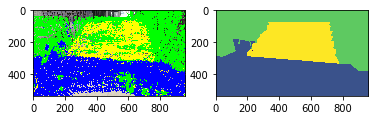

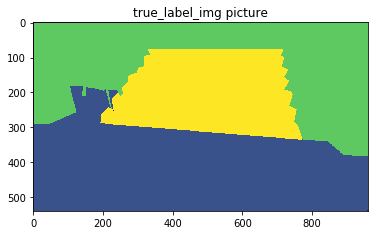

In [37]:
# for i in range(len(test_index)):
for i in range(1, 2, 1):

    index = test_index[i]
    feature_file = feature_path[index]
    rgb_file = rgb_path[index]
    l_file = true_label_path[index]
    
    print(feature_file)
    features_map = np.load(feature_file)
    stair_img = features_map[:,:,4]
    rgb_img = cv2.imread(rgb_file, 1)
    true_label_img = cv2.imread(l_file, 0)
    
#     plt.imshow(rgb_img)
#     plt.title('rgb')
#     plt.show()
    
    hd = features_map[:, :, 0]
    slope = features_map[:, :, 1]
    roughness = features_map[:, :, 2]
    dist = features_map[:, :, 3]
    h_stair = features_map[:, :, 4]
    
    hd = normalize_img(hd, 0.5)
    slope = normalize_img(slope, 0.2)
    roughness = normalize_img(roughness, 0.6)
    dist = normalize_img(dist, dist.max())
    h_stair = normalize_img(h_stair, 1)
    
    predict_img = np.full((rgb_img.shape[0], rgb_img.shape[1]), 0, np.uint8)
    
    for row in range(size, features_map.shape[0]-size, 1):
        for col in range(size, features_map.shape[1]-size, 1):
            feature = features_map[row-size:row+size+1, col-size:col+size+1, :-1].flatten()
            feature_nromalized = scaler.transform([feature])
            
            label = features_map[row, col, -1]
            hd = features_map[row, col, 0]
            print(hd)
            if hd != -1:
                label_pred = int(clf.predict(feature_nromalized)[0])
                if label_pred == 4: #stair
                    cv2.circle(rgb_img, (col, row), 3, (255, 255, 0), -1)
                if label_pred == 3: #obs
                    cv2.circle(rgb_img, (col, row), 3, (0, 255, 0), -1)     
                if label_pred == 2: #rough
                    cv2.circle(rgb_img, (col, row), 3, (0, 255, 255), -1)  
                if label_pred == 1: #safe
                    cv2.circle(rgb_img, (col, row), 3, (0, 0, 255), -1)                      
#                 predict_img[row, col] = label_pred*50
#                 print(label_pred, label)
#     break
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(rgb_img)
    f.add_subplot(1,2, 2)
    plt.imshow(true_label_img)      
    plt.show()  

#     plt.imshow(hd, cmap='gray')
#     plt.title('high difference')
#     plt.show()

#     plt.imshow(slope, cmap='gray')
#     plt.title('slope')
#     plt.show()
    
#     plt.imshow(roughness, cmap='gray')
#     plt.title('roughness')
#     plt.show()
    
#     plt.imshow(h_stair, cmap='gray')
#     plt.title('stair detction')
#     plt.show()
    
    plt.imshow(true_label_img)
    plt.title('true_label_img picture')
    plt.show()        
                